## GPS Spoofing Detection

### 1. load data and preprocess

In [1]:
# Load Data
import DataLoader
import os
import numpy as np
import config

A, B = DataLoader.load_image_pairs(path=config.SUZHOU_RESIZED) # or config.SWISS_RESIZED
assert A.shape[0]==B.shape[0]
n = A.shape[0]
print(A.shape, B.shape)

# Some configuration
feature_map_file_name = './mid_product/features_suzhou_res34_noeval.h5'#'features_suzhou_res50.h5'
#feature_map_file_name = config.FULL_RESIZED_FEATURE
dst_file_name = './mid_product/dst_suzhou_res34_noeval.npy'# 'dst_suzhou_res50.npy' 
# feature_shape = (512, 18, 26) # SWISS, resnet-18/34
feature_shape = (512, 17, 34) # SUZHOU, 1280x720, resnet-18/34
# feature_shape = (2048, 17, 34) # SUZHOU, resnet-50

(238, 720, 1280, 3) (238, 720, 1280, 3)


In [2]:
# Preprocess data by doing transformation
import torch

A = A.astype(np.float)/255.0
B = B.astype(np.float)/255.0 #.transpose(0,3,1,2)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
x_a = torch.from_numpy((A-mean)/std).permute(0,3,1,2).float()
x_b = torch.from_numpy((B-mean)/std).permute(0,3,1,2).float()
print(x_a.size(), x_b.size())

torch.Size([238, 3, 720, 1280]) torch.Size([238, 3, 720, 1280])


### 2. get feature maps

In [3]:
import torchvision.models as models
from torch import nn

pretrained_model = models.resnet34(pretrained=True)
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
#feature_extractor.eval()
for param in feature_extractor.parameters():
    param.requires_grad = False

In [4]:
# Generate feature map and save
import h5py

def h5_save(fname, f_a, f_b):
    '''save f_a and f_b as fname'''
    with h5py.File(fname,'w') as f:
        f.create_dataset('f_a', data=f_a)
        f.create_dataset('f_b', data=f_b)
    
def h5_read(fname):
    '''read fname and return f_a and f_b'''
    with h5py.File(fname,'r') as f:
        return f['f_a'][:], f['f_b'][:]

if not os.path.exists(feature_map_file_name):
    f_a = np.zeros((n,)+feature_shape)
    f_b = np.zeros((n,)+feature_shape)
    for i in range(n):
        print( "Generating feature maps of %d / %d th pair."%(i+1, n), end='\r')
        a = feature_extractor(x_a[i:i+1,:,:,:])
        b = feature_extractor(x_b[i:i+1,:,:,:])
        f_a[i] = a.detach().numpy()
        f_b[i] = b.detach().numpy()
    h5_save(feature_map_file_name, f_a, f_b)
else:
    print("Feature maps file already exists, we just read it.")
    f_a, f_b = h5_read(feature_map_file_name)

In [5]:
# compute distance between unpaird and paired images
print("A domain feature maps size:", f_a.shape)
dst=np.zeros((n,n))
for shift in range(n):
    for idx in range(n):
        a = f_a[idx:idx+1]
        b = f_b[(idx+shift)%n:(idx+shift)%n+1]
        dst[idx,shift] = np.linalg.norm(a - b)
        print('dst(idx,shift)(%d,%d)=%f' % (idx,shift,dst[idx,shift]))
np.save(dst_file_name, dst)

A domain feature maps size: (238, 512, 17, 34)
dst(idx,shift)(0,0)=486.779659
dst(idx,shift)(1,0)=504.704750
dst(idx,shift)(2,0)=516.527167
dst(idx,shift)(3,0)=462.266385
dst(idx,shift)(4,0)=463.412352
dst(idx,shift)(5,0)=457.799209
dst(idx,shift)(6,0)=449.884906
dst(idx,shift)(7,0)=445.574992
dst(idx,shift)(8,0)=529.200247
dst(idx,shift)(9,0)=514.571221
dst(idx,shift)(10,0)=491.563871
dst(idx,shift)(11,0)=523.365009
dst(idx,shift)(12,0)=492.357696
dst(idx,shift)(13,0)=485.800813
dst(idx,shift)(14,0)=483.212314
dst(idx,shift)(15,0)=454.501576
dst(idx,shift)(16,0)=448.877999
dst(idx,shift)(17,0)=500.429302
dst(idx,shift)(18,0)=459.380651
dst(idx,shift)(19,0)=448.883206
dst(idx,shift)(20,0)=463.383420
dst(idx,shift)(21,0)=430.651094
dst(idx,shift)(22,0)=491.316691
dst(idx,shift)(23,0)=508.793123
dst(idx,shift)(24,0)=516.196994
dst(idx,shift)(25,0)=510.976263
dst(idx,shift)(26,0)=465.885010
dst(idx,shift)(27,0)=454.452876
dst(idx,shift)(28,0)=458.518538
dst(idx,shift)(29,0)=461.120950
dst

dst(idx,shift)(112,1)=486.287061
dst(idx,shift)(113,1)=486.722597
dst(idx,shift)(114,1)=495.841762
dst(idx,shift)(115,1)=480.131557
dst(idx,shift)(116,1)=486.276753
dst(idx,shift)(117,1)=480.337443
dst(idx,shift)(118,1)=493.211308
dst(idx,shift)(119,1)=490.922839
dst(idx,shift)(120,1)=507.255458
dst(idx,shift)(121,1)=492.656211
dst(idx,shift)(122,1)=492.859616
dst(idx,shift)(123,1)=512.226400
dst(idx,shift)(124,1)=511.495947
dst(idx,shift)(125,1)=500.815989
dst(idx,shift)(126,1)=529.018528
dst(idx,shift)(127,1)=504.388812
dst(idx,shift)(128,1)=498.466319
dst(idx,shift)(129,1)=477.435236
dst(idx,shift)(130,1)=490.720011
dst(idx,shift)(131,1)=486.567867
dst(idx,shift)(132,1)=473.098286
dst(idx,shift)(133,1)=482.361762
dst(idx,shift)(134,1)=474.077754
dst(idx,shift)(135,1)=486.176805
dst(idx,shift)(136,1)=514.098706
dst(idx,shift)(137,1)=491.064761
dst(idx,shift)(138,1)=492.121246
dst(idx,shift)(139,1)=488.497314
dst(idx,shift)(140,1)=488.632257
dst(idx,shift)(141,1)=488.689921
dst(idx,sh

dst(idx,shift)(43,3)=497.442237
dst(idx,shift)(44,3)=482.104869
dst(idx,shift)(45,3)=496.916267
dst(idx,shift)(46,3)=508.967569
dst(idx,shift)(47,3)=509.788937
dst(idx,shift)(48,3)=507.781965
dst(idx,shift)(49,3)=506.541738
dst(idx,shift)(50,3)=503.510098
dst(idx,shift)(51,3)=521.573716
dst(idx,shift)(52,3)=502.827436
dst(idx,shift)(53,3)=500.929927
dst(idx,shift)(54,3)=502.319312
dst(idx,shift)(55,3)=494.059012
dst(idx,shift)(56,3)=491.723051
dst(idx,shift)(57,3)=493.356245
dst(idx,shift)(58,3)=485.898241
dst(idx,shift)(59,3)=515.539502
dst(idx,shift)(60,3)=472.468913
dst(idx,shift)(61,3)=488.320798
dst(idx,shift)(62,3)=515.626256
dst(idx,shift)(63,3)=487.252081
dst(idx,shift)(64,3)=504.784470
dst(idx,shift)(65,3)=522.020036
dst(idx,shift)(66,3)=512.186459
dst(idx,shift)(67,3)=497.393426
dst(idx,shift)(68,3)=508.079525
dst(idx,shift)(69,3)=507.427380
dst(idx,shift)(70,3)=504.409390
dst(idx,shift)(71,3)=491.501591
dst(idx,shift)(72,3)=525.875123
dst(idx,shift)(73,3)=474.327207
dst(idx,

dst(idx,shift)(212,4)=485.362262
dst(idx,shift)(213,4)=495.444312
dst(idx,shift)(214,4)=507.559713
dst(idx,shift)(215,4)=480.244429
dst(idx,shift)(216,4)=492.864926
dst(idx,shift)(217,4)=517.208979
dst(idx,shift)(218,4)=525.426028
dst(idx,shift)(219,4)=499.909398
dst(idx,shift)(220,4)=506.212355
dst(idx,shift)(221,4)=495.934057
dst(idx,shift)(222,4)=504.379421
dst(idx,shift)(223,4)=508.580898
dst(idx,shift)(224,4)=520.993197
dst(idx,shift)(225,4)=511.215913
dst(idx,shift)(226,4)=498.289454
dst(idx,shift)(227,4)=516.259397
dst(idx,shift)(228,4)=502.550840
dst(idx,shift)(229,4)=531.825536
dst(idx,shift)(230,4)=474.867118
dst(idx,shift)(231,4)=479.159070
dst(idx,shift)(232,4)=498.332544
dst(idx,shift)(233,4)=509.913780
dst(idx,shift)(234,4)=499.242962
dst(idx,shift)(235,4)=501.211924
dst(idx,shift)(236,4)=502.692146
dst(idx,shift)(237,4)=503.080277
dst(idx,shift)(0,5)=489.295810
dst(idx,shift)(1,5)=492.705737
dst(idx,shift)(2,5)=506.692570
dst(idx,shift)(3,5)=511.939098
dst(idx,shift)(4,5

dst(idx,shift)(161,6)=481.863576
dst(idx,shift)(162,6)=474.603433
dst(idx,shift)(163,6)=500.162766
dst(idx,shift)(164,6)=501.508904
dst(idx,shift)(165,6)=506.003389
dst(idx,shift)(166,6)=492.809351
dst(idx,shift)(167,6)=509.119542
dst(idx,shift)(168,6)=481.321158
dst(idx,shift)(169,6)=489.867549
dst(idx,shift)(170,6)=493.134889
dst(idx,shift)(171,6)=500.148468
dst(idx,shift)(172,6)=483.760364
dst(idx,shift)(173,6)=515.523912
dst(idx,shift)(174,6)=523.222999
dst(idx,shift)(175,6)=491.938521
dst(idx,shift)(176,6)=507.021891
dst(idx,shift)(177,6)=516.829531
dst(idx,shift)(178,6)=502.769338
dst(idx,shift)(179,6)=507.330543
dst(idx,shift)(180,6)=512.813918
dst(idx,shift)(181,6)=521.852232
dst(idx,shift)(182,6)=496.261196
dst(idx,shift)(183,6)=517.561995
dst(idx,shift)(184,6)=512.983104
dst(idx,shift)(185,6)=495.453652
dst(idx,shift)(186,6)=519.928627
dst(idx,shift)(187,6)=509.365301
dst(idx,shift)(188,6)=513.988389
dst(idx,shift)(189,6)=514.561664
dst(idx,shift)(190,6)=485.164780
dst(idx,sh

dst(idx,shift)(108,8)=495.347851
dst(idx,shift)(109,8)=495.455457
dst(idx,shift)(110,8)=504.015442
dst(idx,shift)(111,8)=489.544623
dst(idx,shift)(112,8)=511.055874
dst(idx,shift)(113,8)=502.776153
dst(idx,shift)(114,8)=496.608889
dst(idx,shift)(115,8)=475.537866
dst(idx,shift)(116,8)=516.041544
dst(idx,shift)(117,8)=471.306892
dst(idx,shift)(118,8)=512.277211
dst(idx,shift)(119,8)=521.872236
dst(idx,shift)(120,8)=488.743603
dst(idx,shift)(121,8)=488.835895
dst(idx,shift)(122,8)=481.660286
dst(idx,shift)(123,8)=510.816626
dst(idx,shift)(124,8)=493.161781
dst(idx,shift)(125,8)=482.417036
dst(idx,shift)(126,8)=493.842332
dst(idx,shift)(127,8)=506.083736
dst(idx,shift)(128,8)=501.039898
dst(idx,shift)(129,8)=493.627825
dst(idx,shift)(130,8)=473.918667
dst(idx,shift)(131,8)=513.927113
dst(idx,shift)(132,8)=481.513394
dst(idx,shift)(133,8)=486.702409
dst(idx,shift)(134,8)=488.296642
dst(idx,shift)(135,8)=498.410294
dst(idx,shift)(136,8)=505.588151
dst(idx,shift)(137,8)=501.964803
dst(idx,sh

dst(idx,shift)(53,10)=508.309651
dst(idx,shift)(54,10)=509.327442
dst(idx,shift)(55,10)=514.423985
dst(idx,shift)(56,10)=478.868649
dst(idx,shift)(57,10)=502.599380
dst(idx,shift)(58,10)=511.605800
dst(idx,shift)(59,10)=501.675920
dst(idx,shift)(60,10)=486.778346
dst(idx,shift)(61,10)=492.576322
dst(idx,shift)(62,10)=512.675242
dst(idx,shift)(63,10)=510.149531
dst(idx,shift)(64,10)=489.431904
dst(idx,shift)(65,10)=510.453401
dst(idx,shift)(66,10)=474.601380
dst(idx,shift)(67,10)=486.129694
dst(idx,shift)(68,10)=496.706103
dst(idx,shift)(69,10)=518.194776
dst(idx,shift)(70,10)=500.680513
dst(idx,shift)(71,10)=496.226197
dst(idx,shift)(72,10)=548.173309
dst(idx,shift)(73,10)=519.021765
dst(idx,shift)(74,10)=510.663727
dst(idx,shift)(75,10)=501.605711
dst(idx,shift)(76,10)=507.389819
dst(idx,shift)(77,10)=510.826530
dst(idx,shift)(78,10)=480.787311
dst(idx,shift)(79,10)=481.231113
dst(idx,shift)(80,10)=496.230407
dst(idx,shift)(81,10)=505.410203
dst(idx,shift)(82,10)=524.507996
dst(idx,sh

dst(idx,shift)(42,12)=488.080497
dst(idx,shift)(43,12)=493.127844
dst(idx,shift)(44,12)=484.431214
dst(idx,shift)(45,12)=501.940878
dst(idx,shift)(46,12)=501.190976
dst(idx,shift)(47,12)=499.888763
dst(idx,shift)(48,12)=493.661830
dst(idx,shift)(49,12)=476.890121
dst(idx,shift)(50,12)=520.139630
dst(idx,shift)(51,12)=502.344243
dst(idx,shift)(52,12)=496.846931
dst(idx,shift)(53,12)=522.810529
dst(idx,shift)(54,12)=492.319733
dst(idx,shift)(55,12)=497.671744
dst(idx,shift)(56,12)=497.757119
dst(idx,shift)(57,12)=512.854422
dst(idx,shift)(58,12)=492.609114
dst(idx,shift)(59,12)=484.183599
dst(idx,shift)(60,12)=506.173052
dst(idx,shift)(61,12)=513.970035
dst(idx,shift)(62,12)=497.554975
dst(idx,shift)(63,12)=513.976635
dst(idx,shift)(64,12)=475.993810
dst(idx,shift)(65,12)=492.495375
dst(idx,shift)(66,12)=480.273925
dst(idx,shift)(67,12)=497.294366
dst(idx,shift)(68,12)=505.212519
dst(idx,shift)(69,12)=529.737235
dst(idx,shift)(70,12)=503.211933
dst(idx,shift)(71,12)=514.972453
dst(idx,sh

dst(idx,shift)(14,14)=478.656101
dst(idx,shift)(15,14)=501.719310
dst(idx,shift)(16,14)=486.831474
dst(idx,shift)(17,14)=491.363771
dst(idx,shift)(18,14)=480.077681
dst(idx,shift)(19,14)=481.112725
dst(idx,shift)(20,14)=477.474129
dst(idx,shift)(21,14)=482.145870
dst(idx,shift)(22,14)=509.763149
dst(idx,shift)(23,14)=493.253367
dst(idx,shift)(24,14)=514.688222
dst(idx,shift)(25,14)=505.341703
dst(idx,shift)(26,14)=506.029413
dst(idx,shift)(27,14)=488.707060
dst(idx,shift)(28,14)=503.445802
dst(idx,shift)(29,14)=502.701531
dst(idx,shift)(30,14)=479.413700
dst(idx,shift)(31,14)=477.355580
dst(idx,shift)(32,14)=505.237546
dst(idx,shift)(33,14)=472.147095
dst(idx,shift)(34,14)=501.921433
dst(idx,shift)(35,14)=507.341767
dst(idx,shift)(36,14)=512.534733
dst(idx,shift)(37,14)=508.675294
dst(idx,shift)(38,14)=524.147765
dst(idx,shift)(39,14)=522.436048
dst(idx,shift)(40,14)=495.075448
dst(idx,shift)(41,14)=486.921158
dst(idx,shift)(42,14)=470.760430
dst(idx,shift)(43,14)=496.128571
dst(idx,sh

dst(idx,shift)(195,15)=520.353504
dst(idx,shift)(196,15)=512.470608
dst(idx,shift)(197,15)=510.995545
dst(idx,shift)(198,15)=504.296443
dst(idx,shift)(199,15)=492.963857
dst(idx,shift)(200,15)=515.647646
dst(idx,shift)(201,15)=498.105459
dst(idx,shift)(202,15)=507.365179
dst(idx,shift)(203,15)=499.006759
dst(idx,shift)(204,15)=490.722093
dst(idx,shift)(205,15)=488.572716
dst(idx,shift)(206,15)=498.980317
dst(idx,shift)(207,15)=505.274721
dst(idx,shift)(208,15)=504.246503
dst(idx,shift)(209,15)=509.615840
dst(idx,shift)(210,15)=519.702111
dst(idx,shift)(211,15)=499.780699
dst(idx,shift)(212,15)=511.012718
dst(idx,shift)(213,15)=503.382249
dst(idx,shift)(214,15)=528.271206
dst(idx,shift)(215,15)=479.781903
dst(idx,shift)(216,15)=479.330389
dst(idx,shift)(217,15)=511.737966
dst(idx,shift)(218,15)=499.137806
dst(idx,shift)(219,15)=483.825062
dst(idx,shift)(220,15)=493.470416
dst(idx,shift)(221,15)=510.117219
dst(idx,shift)(222,15)=515.587328
dst(idx,shift)(223,15)=506.715883
dst(idx,shift)

dst(idx,shift)(153,17)=483.655627
dst(idx,shift)(154,17)=498.834461
dst(idx,shift)(155,17)=488.021160
dst(idx,shift)(156,17)=498.511954
dst(idx,shift)(157,17)=491.686172
dst(idx,shift)(158,17)=480.397490
dst(idx,shift)(159,17)=507.166827
dst(idx,shift)(160,17)=484.895347
dst(idx,shift)(161,17)=503.212561
dst(idx,shift)(162,17)=495.509214
dst(idx,shift)(163,17)=527.373981
dst(idx,shift)(164,17)=508.520745
dst(idx,shift)(165,17)=476.705072
dst(idx,shift)(166,17)=510.899331
dst(idx,shift)(167,17)=497.642733
dst(idx,shift)(168,17)=495.618250
dst(idx,shift)(169,17)=503.949378
dst(idx,shift)(170,17)=500.999648
dst(idx,shift)(171,17)=486.180800
dst(idx,shift)(172,17)=511.701799
dst(idx,shift)(173,17)=506.596919
dst(idx,shift)(174,17)=487.427766
dst(idx,shift)(175,17)=513.152034
dst(idx,shift)(176,17)=536.709658
dst(idx,shift)(177,17)=513.871208
dst(idx,shift)(178,17)=506.432987
dst(idx,shift)(179,17)=487.751223
dst(idx,shift)(180,17)=513.548872
dst(idx,shift)(181,17)=514.629742
dst(idx,shift)

dst(idx,shift)(170,19)=487.445853
dst(idx,shift)(171,19)=492.934893
dst(idx,shift)(172,19)=487.471455
dst(idx,shift)(173,19)=512.684622
dst(idx,shift)(174,19)=508.860430
dst(idx,shift)(175,19)=516.275907
dst(idx,shift)(176,19)=533.971785
dst(idx,shift)(177,19)=499.586523
dst(idx,shift)(178,19)=482.408588
dst(idx,shift)(179,19)=505.520089
dst(idx,shift)(180,19)=521.320846
dst(idx,shift)(181,19)=502.059759
dst(idx,shift)(182,19)=494.784902
dst(idx,shift)(183,19)=505.316535
dst(idx,shift)(184,19)=506.802665
dst(idx,shift)(185,19)=497.128836
dst(idx,shift)(186,19)=511.838335
dst(idx,shift)(187,19)=503.798159
dst(idx,shift)(188,19)=498.294041
dst(idx,shift)(189,19)=488.171104
dst(idx,shift)(190,19)=492.531180
dst(idx,shift)(191,19)=508.751143
dst(idx,shift)(192,19)=520.925331
dst(idx,shift)(193,19)=515.368579
dst(idx,shift)(194,19)=486.550561
dst(idx,shift)(195,19)=513.001559
dst(idx,shift)(196,19)=499.238048
dst(idx,shift)(197,19)=488.897901
dst(idx,shift)(198,19)=502.801932
dst(idx,shift)

dst(idx,shift)(38,21)=524.878343
dst(idx,shift)(39,21)=505.755737
dst(idx,shift)(40,21)=479.150021
dst(idx,shift)(41,21)=488.480864
dst(idx,shift)(42,21)=483.522428
dst(idx,shift)(43,21)=497.447643
dst(idx,shift)(44,21)=503.028056
dst(idx,shift)(45,21)=494.135046
dst(idx,shift)(46,21)=521.543388
dst(idx,shift)(47,21)=510.286083
dst(idx,shift)(48,21)=511.835224
dst(idx,shift)(49,21)=487.576677
dst(idx,shift)(50,21)=504.663711
dst(idx,shift)(51,21)=526.378618
dst(idx,shift)(52,21)=506.988108
dst(idx,shift)(53,21)=499.422692
dst(idx,shift)(54,21)=518.543070
dst(idx,shift)(55,21)=485.912846
dst(idx,shift)(56,21)=469.550270
dst(idx,shift)(57,21)=498.921922
dst(idx,shift)(58,21)=492.848461
dst(idx,shift)(59,21)=496.877619
dst(idx,shift)(60,21)=504.293445
dst(idx,shift)(61,21)=516.514727
dst(idx,shift)(62,21)=507.654946
dst(idx,shift)(63,21)=499.139503
dst(idx,shift)(64,21)=491.191884
dst(idx,shift)(65,21)=505.453272
dst(idx,shift)(66,21)=494.699107
dst(idx,shift)(67,21)=496.437840
dst(idx,sh

dst(idx,shift)(226,22)=496.882291
dst(idx,shift)(227,22)=518.446331
dst(idx,shift)(228,22)=498.545605
dst(idx,shift)(229,22)=518.310227
dst(idx,shift)(230,22)=493.227273
dst(idx,shift)(231,22)=505.234055
dst(idx,shift)(232,22)=496.159005
dst(idx,shift)(233,22)=484.980361
dst(idx,shift)(234,22)=464.792330
dst(idx,shift)(235,22)=475.081022
dst(idx,shift)(236,22)=490.039770
dst(idx,shift)(237,22)=502.175216
dst(idx,shift)(0,23)=499.578467
dst(idx,shift)(1,23)=504.023000
dst(idx,shift)(2,23)=511.727389
dst(idx,shift)(3,23)=506.884788
dst(idx,shift)(4,23)=497.688973
dst(idx,shift)(5,23)=508.969159
dst(idx,shift)(6,23)=489.230623
dst(idx,shift)(7,23)=505.105285
dst(idx,shift)(8,23)=505.904641
dst(idx,shift)(9,23)=514.760146
dst(idx,shift)(10,23)=491.845333
dst(idx,shift)(11,23)=499.552028
dst(idx,shift)(12,23)=488.888953
dst(idx,shift)(13,23)=486.581220
dst(idx,shift)(14,23)=472.268130
dst(idx,shift)(15,23)=508.807998
dst(idx,shift)(16,23)=494.609868
dst(idx,shift)(17,23)=491.877768
dst(idx,

dst(idx,shift)(177,24)=506.172712
dst(idx,shift)(178,24)=473.770051
dst(idx,shift)(179,24)=492.194856
dst(idx,shift)(180,24)=524.144292
dst(idx,shift)(181,24)=496.571222
dst(idx,shift)(182,24)=494.952558
dst(idx,shift)(183,24)=490.757948
dst(idx,shift)(184,24)=488.340526
dst(idx,shift)(185,24)=487.394389
dst(idx,shift)(186,24)=503.064003
dst(idx,shift)(187,24)=504.225551
dst(idx,shift)(188,24)=524.764567
dst(idx,shift)(189,24)=503.237819
dst(idx,shift)(190,24)=500.763915
dst(idx,shift)(191,24)=479.173705
dst(idx,shift)(192,24)=503.359779
dst(idx,shift)(193,24)=500.556648
dst(idx,shift)(194,24)=511.906140
dst(idx,shift)(195,24)=496.531321
dst(idx,shift)(196,24)=496.355980
dst(idx,shift)(197,24)=502.732367
dst(idx,shift)(198,24)=505.839309
dst(idx,shift)(199,24)=514.550695
dst(idx,shift)(200,24)=522.281428
dst(idx,shift)(201,24)=498.126224
dst(idx,shift)(202,24)=491.587130
dst(idx,shift)(203,24)=519.763667
dst(idx,shift)(204,24)=521.610759
dst(idx,shift)(205,24)=525.672758
dst(idx,shift)

dst(idx,shift)(127,26)=525.072920
dst(idx,shift)(128,26)=509.741241
dst(idx,shift)(129,26)=474.372046
dst(idx,shift)(130,26)=492.335743
dst(idx,shift)(131,26)=484.928812
dst(idx,shift)(132,26)=457.602334
dst(idx,shift)(133,26)=492.265779
dst(idx,shift)(134,26)=490.896680
dst(idx,shift)(135,26)=501.585764
dst(idx,shift)(136,26)=499.570661
dst(idx,shift)(137,26)=504.006439
dst(idx,shift)(138,26)=487.063440
dst(idx,shift)(139,26)=504.778733
dst(idx,shift)(140,26)=509.956421
dst(idx,shift)(141,26)=478.753769
dst(idx,shift)(142,26)=485.092215
dst(idx,shift)(143,26)=502.973345
dst(idx,shift)(144,26)=489.180609
dst(idx,shift)(145,26)=519.149197
dst(idx,shift)(146,26)=513.545787
dst(idx,shift)(147,26)=528.064640
dst(idx,shift)(148,26)=519.990189
dst(idx,shift)(149,26)=501.886492
dst(idx,shift)(150,26)=507.533123
dst(idx,shift)(151,26)=503.557514
dst(idx,shift)(152,26)=500.701020
dst(idx,shift)(153,26)=493.625249
dst(idx,shift)(154,26)=505.658878
dst(idx,shift)(155,26)=501.403174
dst(idx,shift)

dst(idx,shift)(75,28)=515.265205
dst(idx,shift)(76,28)=517.185504
dst(idx,shift)(77,28)=520.790768
dst(idx,shift)(78,28)=474.420836
dst(idx,shift)(79,28)=487.027080
dst(idx,shift)(80,28)=498.350702
dst(idx,shift)(81,28)=520.807723
dst(idx,shift)(82,28)=502.233737
dst(idx,shift)(83,28)=501.474550
dst(idx,shift)(84,28)=505.602597
dst(idx,shift)(85,28)=504.410921
dst(idx,shift)(86,28)=505.324187
dst(idx,shift)(87,28)=479.126301
dst(idx,shift)(88,28)=498.360546
dst(idx,shift)(89,28)=494.834079
dst(idx,shift)(90,28)=494.542540
dst(idx,shift)(91,28)=499.921455
dst(idx,shift)(92,28)=505.934324
dst(idx,shift)(93,28)=492.535342
dst(idx,shift)(94,28)=467.153378
dst(idx,shift)(95,28)=507.688467
dst(idx,shift)(96,28)=504.797708
dst(idx,shift)(97,28)=504.129344
dst(idx,shift)(98,28)=515.382067
dst(idx,shift)(99,28)=525.589314
dst(idx,shift)(100,28)=487.404580
dst(idx,shift)(101,28)=523.227334
dst(idx,shift)(102,28)=498.373785
dst(idx,shift)(103,28)=507.778073
dst(idx,shift)(104,28)=490.674395
dst(i

dst(idx,shift)(25,30)=494.852442
dst(idx,shift)(26,30)=508.079414
dst(idx,shift)(27,30)=496.752722
dst(idx,shift)(28,30)=493.008588
dst(idx,shift)(29,30)=490.053862
dst(idx,shift)(30,30)=499.243096
dst(idx,shift)(31,30)=489.699993
dst(idx,shift)(32,30)=487.025244
dst(idx,shift)(33,30)=491.732279
dst(idx,shift)(34,30)=477.002768
dst(idx,shift)(35,30)=510.971584
dst(idx,shift)(36,30)=497.623799
dst(idx,shift)(37,30)=506.750074
dst(idx,shift)(38,30)=533.854080
dst(idx,shift)(39,30)=531.327071
dst(idx,shift)(40,30)=482.040536
dst(idx,shift)(41,30)=484.547995
dst(idx,shift)(42,30)=497.364795
dst(idx,shift)(43,30)=491.475601
dst(idx,shift)(44,30)=502.880636
dst(idx,shift)(45,30)=514.488727
dst(idx,shift)(46,30)=494.226999
dst(idx,shift)(47,30)=472.216524
dst(idx,shift)(48,30)=502.765677
dst(idx,shift)(49,30)=484.304166
dst(idx,shift)(50,30)=504.709753
dst(idx,shift)(51,30)=503.709131
dst(idx,shift)(52,30)=501.302540
dst(idx,shift)(53,30)=507.774521
dst(idx,shift)(54,30)=488.426521
dst(idx,sh

dst(idx,shift)(11,32)=518.978947
dst(idx,shift)(12,32)=488.722590
dst(idx,shift)(13,32)=472.382699
dst(idx,shift)(14,32)=477.772590
dst(idx,shift)(15,32)=486.201022
dst(idx,shift)(16,32)=499.729132
dst(idx,shift)(17,32)=497.707206
dst(idx,shift)(18,32)=483.845149
dst(idx,shift)(19,32)=496.325777
dst(idx,shift)(20,32)=512.855011
dst(idx,shift)(21,32)=482.848406
dst(idx,shift)(22,32)=505.098415
dst(idx,shift)(23,32)=496.550899
dst(idx,shift)(24,32)=494.158635
dst(idx,shift)(25,32)=495.649264
dst(idx,shift)(26,32)=511.334801
dst(idx,shift)(27,32)=495.637077
dst(idx,shift)(28,32)=500.980690
dst(idx,shift)(29,32)=491.578640
dst(idx,shift)(30,32)=499.956780
dst(idx,shift)(31,32)=484.465066
dst(idx,shift)(32,32)=498.384384
dst(idx,shift)(33,32)=494.538665
dst(idx,shift)(34,32)=484.109364
dst(idx,shift)(35,32)=517.411685
dst(idx,shift)(36,32)=523.807186
dst(idx,shift)(37,32)=520.968091
dst(idx,shift)(38,32)=505.037071
dst(idx,shift)(39,32)=505.657174
dst(idx,shift)(40,32)=503.114163
dst(idx,sh

dst(idx,shift)(221,33)=505.450693
dst(idx,shift)(222,33)=510.531501
dst(idx,shift)(223,33)=482.436003
dst(idx,shift)(224,33)=490.985340
dst(idx,shift)(225,33)=482.356210
dst(idx,shift)(226,33)=496.681931
dst(idx,shift)(227,33)=517.644059
dst(idx,shift)(228,33)=504.740077
dst(idx,shift)(229,33)=533.877975
dst(idx,shift)(230,33)=501.182808
dst(idx,shift)(231,33)=483.840771
dst(idx,shift)(232,33)=500.564864
dst(idx,shift)(233,33)=503.616012
dst(idx,shift)(234,33)=485.392452
dst(idx,shift)(235,33)=502.371185
dst(idx,shift)(236,33)=483.776992
dst(idx,shift)(237,33)=504.596204
dst(idx,shift)(0,34)=484.318119
dst(idx,shift)(1,34)=489.657305
dst(idx,shift)(2,34)=523.467617
dst(idx,shift)(3,34)=496.534360
dst(idx,shift)(4,34)=517.505012
dst(idx,shift)(5,34)=507.784118
dst(idx,shift)(6,34)=482.110003
dst(idx,shift)(7,34)=485.647386
dst(idx,shift)(8,34)=517.534307
dst(idx,shift)(9,34)=520.757675
dst(idx,shift)(10,34)=490.000569
dst(idx,shift)(11,34)=516.636357
dst(idx,shift)(12,34)=505.355934
dst

dst(idx,shift)(187,35)=498.537988
dst(idx,shift)(188,35)=497.992105
dst(idx,shift)(189,35)=530.212959
dst(idx,shift)(190,35)=493.126258
dst(idx,shift)(191,35)=490.712649
dst(idx,shift)(192,35)=530.358429
dst(idx,shift)(193,35)=502.289880
dst(idx,shift)(194,35)=519.641828
dst(idx,shift)(195,35)=501.144818
dst(idx,shift)(196,35)=487.933327
dst(idx,shift)(197,35)=495.890790
dst(idx,shift)(198,35)=501.707970
dst(idx,shift)(199,35)=487.684248
dst(idx,shift)(200,35)=494.882379
dst(idx,shift)(201,35)=506.964194
dst(idx,shift)(202,35)=510.734974
dst(idx,shift)(203,35)=509.075715
dst(idx,shift)(204,35)=489.449351
dst(idx,shift)(205,35)=486.953563
dst(idx,shift)(206,35)=487.674946
dst(idx,shift)(207,35)=488.995715
dst(idx,shift)(208,35)=506.459840
dst(idx,shift)(209,35)=497.913614
dst(idx,shift)(210,35)=493.890411
dst(idx,shift)(211,35)=526.289834
dst(idx,shift)(212,35)=488.960662
dst(idx,shift)(213,35)=509.160662
dst(idx,shift)(214,35)=513.744081
dst(idx,shift)(215,35)=484.223178
dst(idx,shift)

dst(idx,shift)(110,37)=538.591285
dst(idx,shift)(111,37)=489.318726
dst(idx,shift)(112,37)=500.072459
dst(idx,shift)(113,37)=487.017500
dst(idx,shift)(114,37)=501.640867
dst(idx,shift)(115,37)=498.716590
dst(idx,shift)(116,37)=513.765863
dst(idx,shift)(117,37)=480.218975
dst(idx,shift)(118,37)=476.999658
dst(idx,shift)(119,37)=496.762997
dst(idx,shift)(120,37)=480.894878
dst(idx,shift)(121,37)=481.083124
dst(idx,shift)(122,37)=481.025544
dst(idx,shift)(123,37)=497.345700
dst(idx,shift)(124,37)=501.999542
dst(idx,shift)(125,37)=478.087774
dst(idx,shift)(126,37)=528.688226
dst(idx,shift)(127,37)=517.522485
dst(idx,shift)(128,37)=502.475920
dst(idx,shift)(129,37)=491.596940
dst(idx,shift)(130,37)=478.612647
dst(idx,shift)(131,37)=472.043766
dst(idx,shift)(132,37)=494.394304
dst(idx,shift)(133,37)=500.157094
dst(idx,shift)(134,37)=491.222309
dst(idx,shift)(135,37)=489.612754
dst(idx,shift)(136,37)=505.129879
dst(idx,shift)(137,37)=498.367113
dst(idx,shift)(138,37)=482.868494
dst(idx,shift)

dst(idx,shift)(76,39)=494.620957
dst(idx,shift)(77,39)=511.756423
dst(idx,shift)(78,39)=466.010618
dst(idx,shift)(79,39)=472.221422
dst(idx,shift)(80,39)=497.944555
dst(idx,shift)(81,39)=505.376289
dst(idx,shift)(82,39)=510.559109
dst(idx,shift)(83,39)=492.657890
dst(idx,shift)(84,39)=494.913859
dst(idx,shift)(85,39)=519.171394
dst(idx,shift)(86,39)=495.029653
dst(idx,shift)(87,39)=518.110119
dst(idx,shift)(88,39)=528.114077
dst(idx,shift)(89,39)=504.970916
dst(idx,shift)(90,39)=510.250897
dst(idx,shift)(91,39)=485.312987
dst(idx,shift)(92,39)=505.324495
dst(idx,shift)(93,39)=481.709585
dst(idx,shift)(94,39)=486.288351
dst(idx,shift)(95,39)=485.757800
dst(idx,shift)(96,39)=506.681691
dst(idx,shift)(97,39)=496.071201
dst(idx,shift)(98,39)=516.465892
dst(idx,shift)(99,39)=488.108531
dst(idx,shift)(100,39)=488.920387
dst(idx,shift)(101,39)=503.347794
dst(idx,shift)(102,39)=505.243957
dst(idx,shift)(103,39)=489.389474
dst(idx,shift)(104,39)=500.787908
dst(idx,shift)(105,39)=488.157740
dst(

dst(idx,shift)(106,41)=522.900865
dst(idx,shift)(107,41)=497.083400
dst(idx,shift)(108,41)=501.726637
dst(idx,shift)(109,41)=496.105865
dst(idx,shift)(110,41)=481.764323
dst(idx,shift)(111,41)=503.480141
dst(idx,shift)(112,41)=511.833638
dst(idx,shift)(113,41)=502.629006
dst(idx,shift)(114,41)=490.278342
dst(idx,shift)(115,41)=500.738663
dst(idx,shift)(116,41)=484.044101
dst(idx,shift)(117,41)=467.988231
dst(idx,shift)(118,41)=495.411122
dst(idx,shift)(119,41)=494.198039
dst(idx,shift)(120,41)=503.249720
dst(idx,shift)(121,41)=488.022919
dst(idx,shift)(122,41)=502.822124
dst(idx,shift)(123,41)=503.975826
dst(idx,shift)(124,41)=505.846197
dst(idx,shift)(125,41)=494.413297
dst(idx,shift)(126,41)=494.405583
dst(idx,shift)(127,41)=489.982195
dst(idx,shift)(128,41)=513.532215
dst(idx,shift)(129,41)=482.554180
dst(idx,shift)(130,41)=500.050682
dst(idx,shift)(131,41)=492.334596
dst(idx,shift)(132,41)=490.303266
dst(idx,shift)(133,41)=494.814331
dst(idx,shift)(134,41)=490.088948
dst(idx,shift)

dst(idx,shift)(140,43)=524.505113
dst(idx,shift)(141,43)=515.663676
dst(idx,shift)(142,43)=506.572975
dst(idx,shift)(143,43)=494.967988
dst(idx,shift)(144,43)=509.395692
dst(idx,shift)(145,43)=507.290411
dst(idx,shift)(146,43)=513.728280
dst(idx,shift)(147,43)=527.075209
dst(idx,shift)(148,43)=498.884461
dst(idx,shift)(149,43)=497.751829
dst(idx,shift)(150,43)=506.484036
dst(idx,shift)(151,43)=483.179029
dst(idx,shift)(152,43)=513.536782
dst(idx,shift)(153,43)=486.527255
dst(idx,shift)(154,43)=496.688727
dst(idx,shift)(155,43)=501.708202
dst(idx,shift)(156,43)=523.360878
dst(idx,shift)(157,43)=491.189529
dst(idx,shift)(158,43)=477.216479
dst(idx,shift)(159,43)=501.402283
dst(idx,shift)(160,43)=498.777603
dst(idx,shift)(161,43)=498.889262
dst(idx,shift)(162,43)=477.987893
dst(idx,shift)(163,43)=507.794611
dst(idx,shift)(164,43)=511.705299
dst(idx,shift)(165,43)=501.043286
dst(idx,shift)(166,43)=487.050841
dst(idx,shift)(167,43)=498.055161
dst(idx,shift)(168,43)=510.715329
dst(idx,shift)

dst(idx,shift)(181,45)=489.724894
dst(idx,shift)(182,45)=519.901153
dst(idx,shift)(183,45)=504.005219
dst(idx,shift)(184,45)=509.682866
dst(idx,shift)(185,45)=500.846601
dst(idx,shift)(186,45)=511.236775
dst(idx,shift)(187,45)=503.669737
dst(idx,shift)(188,45)=501.385118
dst(idx,shift)(189,45)=489.839437
dst(idx,shift)(190,45)=490.201352
dst(idx,shift)(191,45)=480.044758
dst(idx,shift)(192,45)=528.452060
dst(idx,shift)(193,45)=484.018712
dst(idx,shift)(194,45)=499.530798
dst(idx,shift)(195,45)=505.310386
dst(idx,shift)(196,45)=505.424544
dst(idx,shift)(197,45)=495.078713
dst(idx,shift)(198,45)=504.029355
dst(idx,shift)(199,45)=489.675942
dst(idx,shift)(200,45)=501.936649
dst(idx,shift)(201,45)=539.699391
dst(idx,shift)(202,45)=506.837646
dst(idx,shift)(203,45)=503.159709
dst(idx,shift)(204,45)=518.793371
dst(idx,shift)(205,45)=492.997161
dst(idx,shift)(206,45)=501.100467
dst(idx,shift)(207,45)=488.351480
dst(idx,shift)(208,45)=505.362061
dst(idx,shift)(209,45)=501.395835
dst(idx,shift)

dst(idx,shift)(220,47)=489.641640
dst(idx,shift)(221,47)=502.367938
dst(idx,shift)(222,47)=496.472177
dst(idx,shift)(223,47)=502.966260
dst(idx,shift)(224,47)=511.640071
dst(idx,shift)(225,47)=495.215410
dst(idx,shift)(226,47)=481.240670
dst(idx,shift)(227,47)=512.787359
dst(idx,shift)(228,47)=492.671641
dst(idx,shift)(229,47)=529.022914
dst(idx,shift)(230,47)=503.281939
dst(idx,shift)(231,47)=470.770765
dst(idx,shift)(232,47)=490.202483
dst(idx,shift)(233,47)=500.281421
dst(idx,shift)(234,47)=498.278456
dst(idx,shift)(235,47)=493.163654
dst(idx,shift)(236,47)=488.788421
dst(idx,shift)(237,47)=514.670112
dst(idx,shift)(0,48)=502.519089
dst(idx,shift)(1,48)=493.042959
dst(idx,shift)(2,48)=517.320583
dst(idx,shift)(3,48)=508.025459
dst(idx,shift)(4,48)=514.961442
dst(idx,shift)(5,48)=494.729783
dst(idx,shift)(6,48)=507.206718
dst(idx,shift)(7,48)=511.898160
dst(idx,shift)(8,48)=502.855205
dst(idx,shift)(9,48)=509.945014
dst(idx,shift)(10,48)=486.922455
dst(idx,shift)(11,48)=512.930143
ds

dst(idx,shift)(22,50)=505.215943
dst(idx,shift)(23,50)=508.759074
dst(idx,shift)(24,50)=508.809518
dst(idx,shift)(25,50)=509.893468
dst(idx,shift)(26,50)=501.640565
dst(idx,shift)(27,50)=482.096392
dst(idx,shift)(28,50)=500.484879
dst(idx,shift)(29,50)=490.181788
dst(idx,shift)(30,50)=485.028644
dst(idx,shift)(31,50)=496.952896
dst(idx,shift)(32,50)=501.849418
dst(idx,shift)(33,50)=507.860293
dst(idx,shift)(34,50)=497.605453
dst(idx,shift)(35,50)=502.571191
dst(idx,shift)(36,50)=500.605646
dst(idx,shift)(37,50)=506.131009
dst(idx,shift)(38,50)=522.269350
dst(idx,shift)(39,50)=499.498756
dst(idx,shift)(40,50)=498.004434
dst(idx,shift)(41,50)=488.947691
dst(idx,shift)(42,50)=496.625117
dst(idx,shift)(43,50)=493.079349
dst(idx,shift)(44,50)=484.828417
dst(idx,shift)(45,50)=477.283282
dst(idx,shift)(46,50)=523.106498
dst(idx,shift)(47,50)=508.076314
dst(idx,shift)(48,50)=513.646791
dst(idx,shift)(49,50)=492.249062
dst(idx,shift)(50,50)=497.951651
dst(idx,shift)(51,50)=524.820771
dst(idx,sh

dst(idx,shift)(100,52)=495.960165
dst(idx,shift)(101,52)=517.863309
dst(idx,shift)(102,52)=520.405984
dst(idx,shift)(103,52)=472.306403
dst(idx,shift)(104,52)=504.417360
dst(idx,shift)(105,52)=486.028631
dst(idx,shift)(106,52)=467.622865
dst(idx,shift)(107,52)=481.023254
dst(idx,shift)(108,52)=497.362939
dst(idx,shift)(109,52)=511.875583
dst(idx,shift)(110,52)=500.920333
dst(idx,shift)(111,52)=502.427065
dst(idx,shift)(112,52)=495.058190
dst(idx,shift)(113,52)=498.531208
dst(idx,shift)(114,52)=517.942023
dst(idx,shift)(115,52)=471.301515
dst(idx,shift)(116,52)=483.834788
dst(idx,shift)(117,52)=502.419218
dst(idx,shift)(118,52)=495.003128
dst(idx,shift)(119,52)=488.563282
dst(idx,shift)(120,52)=489.083437
dst(idx,shift)(121,52)=506.372997
dst(idx,shift)(122,52)=487.424604
dst(idx,shift)(123,52)=497.253158
dst(idx,shift)(124,52)=532.922122
dst(idx,shift)(125,52)=498.298097
dst(idx,shift)(126,52)=502.117511
dst(idx,shift)(127,52)=515.394077
dst(idx,shift)(128,52)=516.129726
dst(idx,shift)

dst(idx,shift)(146,54)=497.614466
dst(idx,shift)(147,54)=513.498549
dst(idx,shift)(148,54)=508.781149
dst(idx,shift)(149,54)=491.065946
dst(idx,shift)(150,54)=501.956979
dst(idx,shift)(151,54)=485.492853
dst(idx,shift)(152,54)=512.242580
dst(idx,shift)(153,54)=494.565405
dst(idx,shift)(154,54)=487.590098
dst(idx,shift)(155,54)=488.323783
dst(idx,shift)(156,54)=520.884276
dst(idx,shift)(157,54)=496.561134
dst(idx,shift)(158,54)=491.977512
dst(idx,shift)(159,54)=492.998539
dst(idx,shift)(160,54)=482.286110
dst(idx,shift)(161,54)=489.328474
dst(idx,shift)(162,54)=484.788335
dst(idx,shift)(163,54)=507.387800
dst(idx,shift)(164,54)=513.870834
dst(idx,shift)(165,54)=502.027360
dst(idx,shift)(166,54)=497.424438
dst(idx,shift)(167,54)=495.294913
dst(idx,shift)(168,54)=495.486639
dst(idx,shift)(169,54)=497.939225
dst(idx,shift)(170,54)=492.017638
dst(idx,shift)(171,54)=491.817534
dst(idx,shift)(172,54)=490.544315
dst(idx,shift)(173,54)=524.590932
dst(idx,shift)(174,54)=512.770798
dst(idx,shift)

dst(idx,shift)(143,56)=501.577880
dst(idx,shift)(144,56)=494.353352
dst(idx,shift)(145,56)=511.668840
dst(idx,shift)(146,56)=512.092083
dst(idx,shift)(147,56)=510.625283
dst(idx,shift)(148,56)=519.534363
dst(idx,shift)(149,56)=499.652730
dst(idx,shift)(150,56)=505.214100
dst(idx,shift)(151,56)=477.851599
dst(idx,shift)(152,56)=488.146121
dst(idx,shift)(153,56)=480.809592
dst(idx,shift)(154,56)=500.328641
dst(idx,shift)(155,56)=505.358609
dst(idx,shift)(156,56)=517.905092
dst(idx,shift)(157,56)=491.132241
dst(idx,shift)(158,56)=482.165800
dst(idx,shift)(159,56)=484.917427
dst(idx,shift)(160,56)=491.760270
dst(idx,shift)(161,56)=493.441785
dst(idx,shift)(162,56)=501.814200
dst(idx,shift)(163,56)=498.345495
dst(idx,shift)(164,56)=502.400745
dst(idx,shift)(165,56)=503.189611
dst(idx,shift)(166,56)=498.293746
dst(idx,shift)(167,56)=491.332814
dst(idx,shift)(168,56)=501.123727
dst(idx,shift)(169,56)=502.777982
dst(idx,shift)(170,56)=465.675709
dst(idx,shift)(171,56)=512.712491
dst(idx,shift)

dst(idx,shift)(88,58)=535.348442
dst(idx,shift)(89,58)=540.221405
dst(idx,shift)(90,58)=486.324589
dst(idx,shift)(91,58)=498.774586
dst(idx,shift)(92,58)=492.927803
dst(idx,shift)(93,58)=484.508866
dst(idx,shift)(94,58)=498.119688
dst(idx,shift)(95,58)=507.517191
dst(idx,shift)(96,58)=517.428527
dst(idx,shift)(97,58)=490.618269
dst(idx,shift)(98,58)=512.384716
dst(idx,shift)(99,58)=506.156741
dst(idx,shift)(100,58)=472.075969
dst(idx,shift)(101,58)=481.660126
dst(idx,shift)(102,58)=512.077269
dst(idx,shift)(103,58)=501.125400
dst(idx,shift)(104,58)=489.596140
dst(idx,shift)(105,58)=497.645815
dst(idx,shift)(106,58)=499.993610
dst(idx,shift)(107,58)=505.273054
dst(idx,shift)(108,58)=499.801582
dst(idx,shift)(109,58)=482.409141
dst(idx,shift)(110,58)=481.591650
dst(idx,shift)(111,58)=498.231523
dst(idx,shift)(112,58)=492.600687
dst(idx,shift)(113,58)=511.419805
dst(idx,shift)(114,58)=512.015887
dst(idx,shift)(115,58)=493.474677
dst(idx,shift)(116,58)=498.998576
dst(idx,shift)(117,58)=493

dst(idx,shift)(37,60)=523.266613
dst(idx,shift)(38,60)=515.681359
dst(idx,shift)(39,60)=510.009929
dst(idx,shift)(40,60)=482.499881
dst(idx,shift)(41,60)=493.884605
dst(idx,shift)(42,60)=482.160521
dst(idx,shift)(43,60)=497.957021
dst(idx,shift)(44,60)=492.575445
dst(idx,shift)(45,60)=510.252438
dst(idx,shift)(46,60)=503.344152
dst(idx,shift)(47,60)=503.240100
dst(idx,shift)(48,60)=498.062065
dst(idx,shift)(49,60)=504.243790
dst(idx,shift)(50,60)=493.235135
dst(idx,shift)(51,60)=490.529252
dst(idx,shift)(52,60)=499.600466
dst(idx,shift)(53,60)=512.150612
dst(idx,shift)(54,60)=504.159701
dst(idx,shift)(55,60)=484.623480
dst(idx,shift)(56,60)=481.259293
dst(idx,shift)(57,60)=500.130348
dst(idx,shift)(58,60)=492.128685
dst(idx,shift)(59,60)=492.869851
dst(idx,shift)(60,60)=502.099128
dst(idx,shift)(61,60)=495.617846
dst(idx,shift)(62,60)=490.117452
dst(idx,shift)(63,60)=498.800623
dst(idx,shift)(64,60)=511.486966
dst(idx,shift)(65,60)=503.580238
dst(idx,shift)(66,60)=504.808870
dst(idx,sh

dst(idx,shift)(226,61)=489.318165
dst(idx,shift)(227,61)=513.365470
dst(idx,shift)(228,61)=489.746732
dst(idx,shift)(229,61)=533.657284
dst(idx,shift)(230,61)=486.383459
dst(idx,shift)(231,61)=487.263190
dst(idx,shift)(232,61)=495.620475
dst(idx,shift)(233,61)=484.868219
dst(idx,shift)(234,61)=502.056412
dst(idx,shift)(235,61)=497.475965
dst(idx,shift)(236,61)=505.854577
dst(idx,shift)(237,61)=489.719077
dst(idx,shift)(0,62)=501.704628
dst(idx,shift)(1,62)=505.030976
dst(idx,shift)(2,62)=495.054908
dst(idx,shift)(3,62)=508.711408
dst(idx,shift)(4,62)=492.532771
dst(idx,shift)(5,62)=503.694269
dst(idx,shift)(6,62)=500.711831
dst(idx,shift)(7,62)=513.132948
dst(idx,shift)(8,62)=505.815606
dst(idx,shift)(9,62)=500.312745
dst(idx,shift)(10,62)=511.231966
dst(idx,shift)(11,62)=521.511555
dst(idx,shift)(12,62)=484.713884
dst(idx,shift)(13,62)=498.403373
dst(idx,shift)(14,62)=481.409588
dst(idx,shift)(15,62)=482.192168
dst(idx,shift)(16,62)=492.018253
dst(idx,shift)(17,62)=493.169553
dst(idx,

dst(idx,shift)(161,63)=502.800752
dst(idx,shift)(162,63)=486.789008
dst(idx,shift)(163,63)=496.850559
dst(idx,shift)(164,63)=527.462314
dst(idx,shift)(165,63)=509.913872
dst(idx,shift)(166,63)=515.447968
dst(idx,shift)(167,63)=494.676771
dst(idx,shift)(168,63)=492.524019
dst(idx,shift)(169,63)=486.925074
dst(idx,shift)(170,63)=474.020873
dst(idx,shift)(171,63)=475.037246
dst(idx,shift)(172,63)=482.339811
dst(idx,shift)(173,63)=503.559962
dst(idx,shift)(174,63)=499.974816
dst(idx,shift)(175,63)=497.861160
dst(idx,shift)(176,63)=517.805731
dst(idx,shift)(177,63)=495.795352
dst(idx,shift)(178,63)=479.683427
dst(idx,shift)(179,63)=495.205941
dst(idx,shift)(180,63)=515.784623
dst(idx,shift)(181,63)=487.314396
dst(idx,shift)(182,63)=489.873175
dst(idx,shift)(183,63)=534.758789
dst(idx,shift)(184,63)=506.055916
dst(idx,shift)(185,63)=486.083224
dst(idx,shift)(186,63)=516.095844
dst(idx,shift)(187,63)=499.954688
dst(idx,shift)(188,63)=503.148886
dst(idx,shift)(189,63)=501.835823
dst(idx,shift)

dst(idx,shift)(103,65)=481.704942
dst(idx,shift)(104,65)=503.008055
dst(idx,shift)(105,65)=494.455419
dst(idx,shift)(106,65)=499.532501
dst(idx,shift)(107,65)=492.688263
dst(idx,shift)(108,65)=507.097056
dst(idx,shift)(109,65)=501.112353
dst(idx,shift)(110,65)=496.738282
dst(idx,shift)(111,65)=507.280881
dst(idx,shift)(112,65)=507.378332
dst(idx,shift)(113,65)=504.209610
dst(idx,shift)(114,65)=511.150914
dst(idx,shift)(115,65)=507.123867
dst(idx,shift)(116,65)=505.351033
dst(idx,shift)(117,65)=484.551398
dst(idx,shift)(118,65)=513.020963
dst(idx,shift)(119,65)=505.141961
dst(idx,shift)(120,65)=508.205748
dst(idx,shift)(121,65)=504.496698
dst(idx,shift)(122,65)=506.846901
dst(idx,shift)(123,65)=520.113247
dst(idx,shift)(124,65)=523.515000
dst(idx,shift)(125,65)=491.644881
dst(idx,shift)(126,65)=501.516104
dst(idx,shift)(127,65)=511.479568
dst(idx,shift)(128,65)=511.320353
dst(idx,shift)(129,65)=497.506572
dst(idx,shift)(130,65)=504.212690
dst(idx,shift)(131,65)=481.333622
dst(idx,shift)

dst(idx,shift)(47,67)=483.553246
dst(idx,shift)(48,67)=471.221180
dst(idx,shift)(49,67)=483.880919
dst(idx,shift)(50,67)=501.550950
dst(idx,shift)(51,67)=496.111531
dst(idx,shift)(52,67)=504.880946
dst(idx,shift)(53,67)=485.771400
dst(idx,shift)(54,67)=507.556645
dst(idx,shift)(55,67)=486.590233
dst(idx,shift)(56,67)=480.053965
dst(idx,shift)(57,67)=502.106190
dst(idx,shift)(58,67)=491.912553
dst(idx,shift)(59,67)=508.404797
dst(idx,shift)(60,67)=514.010992
dst(idx,shift)(61,67)=489.613332
dst(idx,shift)(62,67)=482.611748
dst(idx,shift)(63,67)=497.451600
dst(idx,shift)(64,67)=503.125317
dst(idx,shift)(65,67)=502.049764
dst(idx,shift)(66,67)=477.479253
dst(idx,shift)(67,67)=489.957093
dst(idx,shift)(68,67)=500.949715
dst(idx,shift)(69,67)=511.605823
dst(idx,shift)(70,67)=493.239532
dst(idx,shift)(71,67)=485.130449
dst(idx,shift)(72,67)=507.715580
dst(idx,shift)(73,67)=499.633409
dst(idx,shift)(74,67)=502.579390
dst(idx,shift)(75,67)=494.355772
dst(idx,shift)(76,67)=503.191173
dst(idx,sh

dst(idx,shift)(0,69)=516.733452
dst(idx,shift)(1,69)=488.962393
dst(idx,shift)(2,69)=506.415878
dst(idx,shift)(3,69)=498.536364
dst(idx,shift)(4,69)=509.741297
dst(idx,shift)(5,69)=502.809725
dst(idx,shift)(6,69)=491.721073
dst(idx,shift)(7,69)=489.582691
dst(idx,shift)(8,69)=495.669522
dst(idx,shift)(9,69)=508.845148
dst(idx,shift)(10,69)=495.856476
dst(idx,shift)(11,69)=517.494916
dst(idx,shift)(12,69)=495.427114
dst(idx,shift)(13,69)=508.083067
dst(idx,shift)(14,69)=487.548679
dst(idx,shift)(15,69)=496.295303
dst(idx,shift)(16,69)=479.740861
dst(idx,shift)(17,69)=499.808690
dst(idx,shift)(18,69)=474.229420
dst(idx,shift)(19,69)=487.846364
dst(idx,shift)(20,69)=491.899484
dst(idx,shift)(21,69)=485.940806
dst(idx,shift)(22,69)=501.522023
dst(idx,shift)(23,69)=497.638297
dst(idx,shift)(24,69)=499.414709
dst(idx,shift)(25,69)=484.625430
dst(idx,shift)(26,69)=509.649449
dst(idx,shift)(27,69)=503.876014
dst(idx,shift)(28,69)=505.838589
dst(idx,shift)(29,69)=507.650713
dst(idx,shift)(30,69

dst(idx,shift)(218,70)=525.256280
dst(idx,shift)(219,70)=500.593751
dst(idx,shift)(220,70)=496.839881
dst(idx,shift)(221,70)=506.825553
dst(idx,shift)(222,70)=504.988942
dst(idx,shift)(223,70)=505.154113
dst(idx,shift)(224,70)=512.077985
dst(idx,shift)(225,70)=505.816617
dst(idx,shift)(226,70)=489.334161
dst(idx,shift)(227,70)=525.289775
dst(idx,shift)(228,70)=494.277283
dst(idx,shift)(229,70)=516.489291
dst(idx,shift)(230,70)=505.015015
dst(idx,shift)(231,70)=489.764123
dst(idx,shift)(232,70)=499.106750
dst(idx,shift)(233,70)=512.086850
dst(idx,shift)(234,70)=479.864951
dst(idx,shift)(235,70)=501.099980
dst(idx,shift)(236,70)=503.791413
dst(idx,shift)(237,70)=521.074817
dst(idx,shift)(0,71)=494.349747
dst(idx,shift)(1,71)=501.323707
dst(idx,shift)(2,71)=508.953705
dst(idx,shift)(3,71)=500.038900
dst(idx,shift)(4,71)=514.027582
dst(idx,shift)(5,71)=491.828701
dst(idx,shift)(6,71)=488.779643
dst(idx,shift)(7,71)=496.401171
dst(idx,shift)(8,71)=512.941187
dst(idx,shift)(9,71)=504.409684


dst(idx,shift)(163,72)=487.677158
dst(idx,shift)(164,72)=497.679040
dst(idx,shift)(165,72)=512.678397
dst(idx,shift)(166,72)=503.166161
dst(idx,shift)(167,72)=491.034177
dst(idx,shift)(168,72)=494.665790
dst(idx,shift)(169,72)=496.105483
dst(idx,shift)(170,72)=476.557204
dst(idx,shift)(171,72)=497.712724
dst(idx,shift)(172,72)=492.791975
dst(idx,shift)(173,72)=492.419893
dst(idx,shift)(174,72)=511.532816
dst(idx,shift)(175,72)=504.264062
dst(idx,shift)(176,72)=522.010117
dst(idx,shift)(177,72)=514.577763
dst(idx,shift)(178,72)=478.911589
dst(idx,shift)(179,72)=494.387760
dst(idx,shift)(180,72)=498.650526
dst(idx,shift)(181,72)=517.892588
dst(idx,shift)(182,72)=499.422935
dst(idx,shift)(183,72)=497.110045
dst(idx,shift)(184,72)=490.494370
dst(idx,shift)(185,72)=493.366773
dst(idx,shift)(186,72)=509.107810
dst(idx,shift)(187,72)=501.883194
dst(idx,shift)(188,72)=497.523847
dst(idx,shift)(189,72)=509.318788
dst(idx,shift)(190,72)=514.432543
dst(idx,shift)(191,72)=498.933840
dst(idx,shift)

dst(idx,shift)(103,74)=509.825622
dst(idx,shift)(104,74)=491.947523
dst(idx,shift)(105,74)=512.415128
dst(idx,shift)(106,74)=498.079625
dst(idx,shift)(107,74)=511.775593
dst(idx,shift)(108,74)=495.405114
dst(idx,shift)(109,74)=523.673096
dst(idx,shift)(110,74)=519.623964
dst(idx,shift)(111,74)=497.298739
dst(idx,shift)(112,74)=511.542698
dst(idx,shift)(113,74)=532.004975
dst(idx,shift)(114,74)=493.291747
dst(idx,shift)(115,74)=499.977022
dst(idx,shift)(116,74)=503.721040
dst(idx,shift)(117,74)=475.498373
dst(idx,shift)(118,74)=504.424177
dst(idx,shift)(119,74)=491.461021
dst(idx,shift)(120,74)=499.010738
dst(idx,shift)(121,74)=512.019076
dst(idx,shift)(122,74)=489.779843
dst(idx,shift)(123,74)=510.118200
dst(idx,shift)(124,74)=522.206883
dst(idx,shift)(125,74)=496.215024
dst(idx,shift)(126,74)=510.310444
dst(idx,shift)(127,74)=506.155987
dst(idx,shift)(128,74)=506.791057
dst(idx,shift)(129,74)=494.952913
dst(idx,shift)(130,74)=501.067795
dst(idx,shift)(131,74)=491.313189
dst(idx,shift)

dst(idx,shift)(75,76)=495.255090
dst(idx,shift)(76,76)=510.755308
dst(idx,shift)(77,76)=522.446176
dst(idx,shift)(78,76)=484.906897
dst(idx,shift)(79,76)=466.569112
dst(idx,shift)(80,76)=495.508199
dst(idx,shift)(81,76)=512.081791
dst(idx,shift)(82,76)=494.808763
dst(idx,shift)(83,76)=500.170676
dst(idx,shift)(84,76)=499.466618
dst(idx,shift)(85,76)=504.430166
dst(idx,shift)(86,76)=481.949907
dst(idx,shift)(87,76)=516.926551
dst(idx,shift)(88,76)=515.247908
dst(idx,shift)(89,76)=520.966825
dst(idx,shift)(90,76)=504.731410
dst(idx,shift)(91,76)=485.409338
dst(idx,shift)(92,76)=478.492457
dst(idx,shift)(93,76)=507.477452
dst(idx,shift)(94,76)=482.588376
dst(idx,shift)(95,76)=504.367955
dst(idx,shift)(96,76)=509.514752
dst(idx,shift)(97,76)=500.247694
dst(idx,shift)(98,76)=504.487152
dst(idx,shift)(99,76)=490.697942
dst(idx,shift)(100,76)=508.644634
dst(idx,shift)(101,76)=524.073546
dst(idx,shift)(102,76)=511.857787
dst(idx,shift)(103,76)=510.448843
dst(idx,shift)(104,76)=529.380475
dst(i

dst(idx,shift)(19,78)=500.150128
dst(idx,shift)(20,78)=493.958452
dst(idx,shift)(21,78)=486.345058
dst(idx,shift)(22,78)=485.943841
dst(idx,shift)(23,78)=510.369087
dst(idx,shift)(24,78)=502.362989
dst(idx,shift)(25,78)=494.124023
dst(idx,shift)(26,78)=533.087267
dst(idx,shift)(27,78)=500.537791
dst(idx,shift)(28,78)=494.869925
dst(idx,shift)(29,78)=496.606955
dst(idx,shift)(30,78)=493.942058
dst(idx,shift)(31,78)=497.008857
dst(idx,shift)(32,78)=492.488396
dst(idx,shift)(33,78)=494.634450
dst(idx,shift)(34,78)=497.877238
dst(idx,shift)(35,78)=512.336910
dst(idx,shift)(36,78)=484.270472
dst(idx,shift)(37,78)=495.438628
dst(idx,shift)(38,78)=489.813553
dst(idx,shift)(39,78)=476.413699
dst(idx,shift)(40,78)=485.036387
dst(idx,shift)(41,78)=482.641880
dst(idx,shift)(42,78)=501.282503
dst(idx,shift)(43,78)=505.043900
dst(idx,shift)(44,78)=466.674188
dst(idx,shift)(45,78)=491.329820
dst(idx,shift)(46,78)=512.368681
dst(idx,shift)(47,78)=487.721561
dst(idx,shift)(48,78)=512.822048
dst(idx,sh

dst(idx,shift)(195,79)=510.072047
dst(idx,shift)(196,79)=502.090550
dst(idx,shift)(197,79)=505.374228
dst(idx,shift)(198,79)=510.400789
dst(idx,shift)(199,79)=493.150114
dst(idx,shift)(200,79)=496.133116
dst(idx,shift)(201,79)=505.270198
dst(idx,shift)(202,79)=506.908821
dst(idx,shift)(203,79)=500.578627
dst(idx,shift)(204,79)=492.014975
dst(idx,shift)(205,79)=498.913674
dst(idx,shift)(206,79)=478.653856
dst(idx,shift)(207,79)=499.683662
dst(idx,shift)(208,79)=492.873475
dst(idx,shift)(209,79)=515.408308
dst(idx,shift)(210,79)=523.231144
dst(idx,shift)(211,79)=518.375158
dst(idx,shift)(212,79)=488.010184
dst(idx,shift)(213,79)=495.034850
dst(idx,shift)(214,79)=507.324479
dst(idx,shift)(215,79)=479.767170
dst(idx,shift)(216,79)=496.711178
dst(idx,shift)(217,79)=497.439359
dst(idx,shift)(218,79)=511.025069
dst(idx,shift)(219,79)=495.501312
dst(idx,shift)(220,79)=496.242581
dst(idx,shift)(221,79)=526.550902
dst(idx,shift)(222,79)=490.561479
dst(idx,shift)(223,79)=495.649584
dst(idx,shift)

dst(idx,shift)(91,81)=491.859193
dst(idx,shift)(92,81)=501.315185
dst(idx,shift)(93,81)=485.137082
dst(idx,shift)(94,81)=489.392845
dst(idx,shift)(95,81)=512.359066
dst(idx,shift)(96,81)=517.919256
dst(idx,shift)(97,81)=492.951432
dst(idx,shift)(98,81)=533.231346
dst(idx,shift)(99,81)=515.678220
dst(idx,shift)(100,81)=482.988776
dst(idx,shift)(101,81)=489.216139
dst(idx,shift)(102,81)=535.119788
dst(idx,shift)(103,81)=517.685521
dst(idx,shift)(104,81)=503.676701
dst(idx,shift)(105,81)=496.479262
dst(idx,shift)(106,81)=507.249367
dst(idx,shift)(107,81)=498.696330
dst(idx,shift)(108,81)=503.503753
dst(idx,shift)(109,81)=501.243673
dst(idx,shift)(110,81)=491.280911
dst(idx,shift)(111,81)=505.788701
dst(idx,shift)(112,81)=517.596188
dst(idx,shift)(113,81)=501.788183
dst(idx,shift)(114,81)=536.663745
dst(idx,shift)(115,81)=485.836508
dst(idx,shift)(116,81)=510.575692
dst(idx,shift)(117,81)=491.517465
dst(idx,shift)(118,81)=496.712914
dst(idx,shift)(119,81)=494.183125
dst(idx,shift)(120,81)=

dst(idx,shift)(222,82)=494.028422
dst(idx,shift)(223,82)=511.839482
dst(idx,shift)(224,82)=530.383690
dst(idx,shift)(225,82)=500.725482
dst(idx,shift)(226,82)=490.972045
dst(idx,shift)(227,82)=508.000609
dst(idx,shift)(228,82)=513.299591
dst(idx,shift)(229,82)=530.858879
dst(idx,shift)(230,82)=484.582415
dst(idx,shift)(231,82)=509.358287
dst(idx,shift)(232,82)=493.341626
dst(idx,shift)(233,82)=496.002723
dst(idx,shift)(234,82)=479.394916
dst(idx,shift)(235,82)=493.113137
dst(idx,shift)(236,82)=497.713060
dst(idx,shift)(237,82)=500.388809
dst(idx,shift)(0,83)=510.898441
dst(idx,shift)(1,83)=477.276503
dst(idx,shift)(2,83)=500.454869
dst(idx,shift)(3,83)=490.587881
dst(idx,shift)(4,83)=498.747682
dst(idx,shift)(5,83)=499.927743
dst(idx,shift)(6,83)=488.197778
dst(idx,shift)(7,83)=493.568313
dst(idx,shift)(8,83)=521.613398
dst(idx,shift)(9,83)=510.521571
dst(idx,shift)(10,83)=501.348981
dst(idx,shift)(11,83)=506.285745
dst(idx,shift)(12,83)=484.885152
dst(idx,shift)(13,83)=499.713551
dst(

dst(idx,shift)(159,84)=495.670167
dst(idx,shift)(160,84)=476.788037
dst(idx,shift)(161,84)=479.218387
dst(idx,shift)(162,84)=496.511907
dst(idx,shift)(163,84)=513.454262
dst(idx,shift)(164,84)=509.831993
dst(idx,shift)(165,84)=521.927969
dst(idx,shift)(166,84)=496.848912
dst(idx,shift)(167,84)=487.711618
dst(idx,shift)(168,84)=491.493067
dst(idx,shift)(169,84)=496.467354
dst(idx,shift)(170,84)=483.168541
dst(idx,shift)(171,84)=484.284410
dst(idx,shift)(172,84)=467.472459
dst(idx,shift)(173,84)=493.851532
dst(idx,shift)(174,84)=478.149288
dst(idx,shift)(175,84)=502.892937
dst(idx,shift)(176,84)=505.301126
dst(idx,shift)(177,84)=499.040690
dst(idx,shift)(178,84)=489.627792
dst(idx,shift)(179,84)=505.848216
dst(idx,shift)(180,84)=514.056284
dst(idx,shift)(181,84)=507.931830
dst(idx,shift)(182,84)=504.815609
dst(idx,shift)(183,84)=492.865916
dst(idx,shift)(184,84)=497.043196
dst(idx,shift)(185,84)=489.496819
dst(idx,shift)(186,84)=511.250545
dst(idx,shift)(187,84)=501.872163
dst(idx,shift)

dst(idx,shift)(108,86)=511.575871
dst(idx,shift)(109,86)=496.842908
dst(idx,shift)(110,86)=508.355627
dst(idx,shift)(111,86)=502.920523
dst(idx,shift)(112,86)=498.352426
dst(idx,shift)(113,86)=517.194004
dst(idx,shift)(114,86)=514.704438
dst(idx,shift)(115,86)=484.874439
dst(idx,shift)(116,86)=504.491435
dst(idx,shift)(117,86)=489.293836
dst(idx,shift)(118,86)=513.323811
dst(idx,shift)(119,86)=494.756662
dst(idx,shift)(120,86)=509.894308
dst(idx,shift)(121,86)=498.798017
dst(idx,shift)(122,86)=482.833996
dst(idx,shift)(123,86)=492.981595
dst(idx,shift)(124,86)=516.700673
dst(idx,shift)(125,86)=506.453769
dst(idx,shift)(126,86)=518.482419
dst(idx,shift)(127,86)=492.276433
dst(idx,shift)(128,86)=522.454897
dst(idx,shift)(129,86)=484.758722
dst(idx,shift)(130,86)=490.023952
dst(idx,shift)(131,86)=493.393952
dst(idx,shift)(132,86)=494.221594
dst(idx,shift)(133,86)=498.610001
dst(idx,shift)(134,86)=483.103098
dst(idx,shift)(135,86)=497.053864
dst(idx,shift)(136,86)=510.854965
dst(idx,shift)

dst(idx,shift)(103,89)=500.625799
dst(idx,shift)(104,89)=503.888888
dst(idx,shift)(105,89)=502.040797
dst(idx,shift)(106,89)=493.648042
dst(idx,shift)(107,89)=489.815517
dst(idx,shift)(108,89)=508.139851
dst(idx,shift)(109,89)=504.947440
dst(idx,shift)(110,89)=517.555257
dst(idx,shift)(111,89)=502.296941
dst(idx,shift)(112,89)=516.668023
dst(idx,shift)(113,89)=495.327797
dst(idx,shift)(114,89)=506.826454
dst(idx,shift)(115,89)=503.703628
dst(idx,shift)(116,89)=501.254718
dst(idx,shift)(117,89)=496.735193
dst(idx,shift)(118,89)=494.353749
dst(idx,shift)(119,89)=488.056904
dst(idx,shift)(120,89)=488.281397
dst(idx,shift)(121,89)=507.407866
dst(idx,shift)(122,89)=496.024634
dst(idx,shift)(123,89)=497.362221
dst(idx,shift)(124,89)=513.374212
dst(idx,shift)(125,89)=494.644383
dst(idx,shift)(126,89)=505.558255
dst(idx,shift)(127,89)=515.381025
dst(idx,shift)(128,89)=500.948947
dst(idx,shift)(129,89)=503.422733
dst(idx,shift)(130,89)=489.655737
dst(idx,shift)(131,89)=484.988828
dst(idx,shift)

dst(idx,shift)(177,91)=503.848399
dst(idx,shift)(178,91)=469.896228
dst(idx,shift)(179,91)=486.999915
dst(idx,shift)(180,91)=522.945351
dst(idx,shift)(181,91)=491.291221
dst(idx,shift)(182,91)=500.127904
dst(idx,shift)(183,91)=510.701037
dst(idx,shift)(184,91)=501.436322
dst(idx,shift)(185,91)=520.766881
dst(idx,shift)(186,91)=522.699995
dst(idx,shift)(187,91)=494.162604
dst(idx,shift)(188,91)=501.310813
dst(idx,shift)(189,91)=488.392533
dst(idx,shift)(190,91)=507.900337
dst(idx,shift)(191,91)=486.859937
dst(idx,shift)(192,91)=506.993452
dst(idx,shift)(193,91)=503.894373
dst(idx,shift)(194,91)=467.528010
dst(idx,shift)(195,91)=504.989114
dst(idx,shift)(196,91)=495.515616
dst(idx,shift)(197,91)=503.447464
dst(idx,shift)(198,91)=514.201638
dst(idx,shift)(199,91)=500.747695
dst(idx,shift)(200,91)=496.031077
dst(idx,shift)(201,91)=506.265025
dst(idx,shift)(202,91)=508.476007
dst(idx,shift)(203,91)=492.056459
dst(idx,shift)(204,91)=494.073491
dst(idx,shift)(205,91)=479.956232
dst(idx,shift)

dst(idx,shift)(13,94)=487.383233
dst(idx,shift)(14,94)=481.149433
dst(idx,shift)(15,94)=507.884127
dst(idx,shift)(16,94)=495.913533
dst(idx,shift)(17,94)=502.672288
dst(idx,shift)(18,94)=493.397558
dst(idx,shift)(19,94)=489.299195
dst(idx,shift)(20,94)=488.280946
dst(idx,shift)(21,94)=477.585612
dst(idx,shift)(22,94)=484.877034
dst(idx,shift)(23,94)=495.130590
dst(idx,shift)(24,94)=501.994547
dst(idx,shift)(25,94)=500.504423
dst(idx,shift)(26,94)=514.292275
dst(idx,shift)(27,94)=494.624951
dst(idx,shift)(28,94)=500.310372
dst(idx,shift)(29,94)=485.167278
dst(idx,shift)(30,94)=495.840994
dst(idx,shift)(31,94)=477.670281
dst(idx,shift)(32,94)=502.443526
dst(idx,shift)(33,94)=515.223322
dst(idx,shift)(34,94)=476.003487
dst(idx,shift)(35,94)=525.053557
dst(idx,shift)(36,94)=499.009766
dst(idx,shift)(37,94)=507.484926
dst(idx,shift)(38,94)=495.570205
dst(idx,shift)(39,94)=510.183283
dst(idx,shift)(40,94)=476.279746
dst(idx,shift)(41,94)=482.293544
dst(idx,shift)(42,94)=491.504429
dst(idx,sh

dst(idx,shift)(56,96)=494.679660
dst(idx,shift)(57,96)=516.381420
dst(idx,shift)(58,96)=500.365453
dst(idx,shift)(59,96)=469.208623
dst(idx,shift)(60,96)=492.744904
dst(idx,shift)(61,96)=494.393931
dst(idx,shift)(62,96)=480.007311
dst(idx,shift)(63,96)=478.353300
dst(idx,shift)(64,96)=495.572387
dst(idx,shift)(65,96)=498.361037
dst(idx,shift)(66,96)=481.366295
dst(idx,shift)(67,96)=517.585050
dst(idx,shift)(68,96)=519.042080
dst(idx,shift)(69,96)=505.598990
dst(idx,shift)(70,96)=505.308445
dst(idx,shift)(71,96)=474.871767
dst(idx,shift)(72,96)=505.895083
dst(idx,shift)(73,96)=504.598885
dst(idx,shift)(74,96)=513.829725
dst(idx,shift)(75,96)=527.136728
dst(idx,shift)(76,96)=507.881683
dst(idx,shift)(77,96)=517.397227
dst(idx,shift)(78,96)=479.808088
dst(idx,shift)(79,96)=487.683966
dst(idx,shift)(80,96)=510.764491
dst(idx,shift)(81,96)=519.912322
dst(idx,shift)(82,96)=523.970061
dst(idx,shift)(83,96)=501.120756
dst(idx,shift)(84,96)=528.025738
dst(idx,shift)(85,96)=499.526250
dst(idx,sh

dst(idx,shift)(75,98)=530.373717
dst(idx,shift)(76,98)=507.085780
dst(idx,shift)(77,98)=512.330175
dst(idx,shift)(78,98)=496.462858
dst(idx,shift)(79,98)=493.310807
dst(idx,shift)(80,98)=497.685700
dst(idx,shift)(81,98)=522.237980
dst(idx,shift)(82,98)=491.835721
dst(idx,shift)(83,98)=501.226817
dst(idx,shift)(84,98)=494.773169
dst(idx,shift)(85,98)=509.429102
dst(idx,shift)(86,98)=511.742427
dst(idx,shift)(87,98)=514.753598
dst(idx,shift)(88,98)=507.929096
dst(idx,shift)(89,98)=521.108943
dst(idx,shift)(90,98)=513.913296
dst(idx,shift)(91,98)=514.073999
dst(idx,shift)(92,98)=506.189844
dst(idx,shift)(93,98)=486.742616
dst(idx,shift)(94,98)=501.595534
dst(idx,shift)(95,98)=505.080718
dst(idx,shift)(96,98)=517.626976
dst(idx,shift)(97,98)=531.144515
dst(idx,shift)(98,98)=510.938319
dst(idx,shift)(99,98)=508.069738
dst(idx,shift)(100,98)=491.796210
dst(idx,shift)(101,98)=530.706776
dst(idx,shift)(102,98)=510.715601
dst(idx,shift)(103,98)=505.084536
dst(idx,shift)(104,98)=487.614747
dst(i

dst(idx,shift)(110,100)=507.749701
dst(idx,shift)(111,100)=523.018498
dst(idx,shift)(112,100)=515.251753
dst(idx,shift)(113,100)=493.734047
dst(idx,shift)(114,100)=521.703517
dst(idx,shift)(115,100)=480.870895
dst(idx,shift)(116,100)=493.453476
dst(idx,shift)(117,100)=483.529165
dst(idx,shift)(118,100)=507.488729
dst(idx,shift)(119,100)=490.837431
dst(idx,shift)(120,100)=483.779846
dst(idx,shift)(121,100)=513.784530
dst(idx,shift)(122,100)=507.218067
dst(idx,shift)(123,100)=505.128180
dst(idx,shift)(124,100)=511.074189
dst(idx,shift)(125,100)=484.931335
dst(idx,shift)(126,100)=488.775298
dst(idx,shift)(127,100)=518.659479
dst(idx,shift)(128,100)=508.330869
dst(idx,shift)(129,100)=520.840530
dst(idx,shift)(130,100)=480.135214
dst(idx,shift)(131,100)=488.905193
dst(idx,shift)(132,100)=486.056278
dst(idx,shift)(133,100)=487.190344
dst(idx,shift)(134,100)=473.340239
dst(idx,shift)(135,100)=485.180964
dst(idx,shift)(136,100)=502.377498
dst(idx,shift)(137,100)=503.295686
dst(idx,shift)(138,1

dst(idx,shift)(139,102)=495.402563
dst(idx,shift)(140,102)=505.613846
dst(idx,shift)(141,102)=499.851665
dst(idx,shift)(142,102)=487.472026
dst(idx,shift)(143,102)=489.414463
dst(idx,shift)(144,102)=508.089406
dst(idx,shift)(145,102)=506.988821
dst(idx,shift)(146,102)=502.114906
dst(idx,shift)(147,102)=528.480325
dst(idx,shift)(148,102)=505.780695
dst(idx,shift)(149,102)=486.688879
dst(idx,shift)(150,102)=498.859653
dst(idx,shift)(151,102)=497.072296
dst(idx,shift)(152,102)=495.829184
dst(idx,shift)(153,102)=488.748235
dst(idx,shift)(154,102)=466.493055
dst(idx,shift)(155,102)=473.395836
dst(idx,shift)(156,102)=495.258920
dst(idx,shift)(157,102)=475.961112
dst(idx,shift)(158,102)=475.617092
dst(idx,shift)(159,102)=496.627947
dst(idx,shift)(160,102)=497.128871
dst(idx,shift)(161,102)=513.151198
dst(idx,shift)(162,102)=489.140722
dst(idx,shift)(163,102)=501.341584
dst(idx,shift)(164,102)=511.787911
dst(idx,shift)(165,102)=492.270111
dst(idx,shift)(166,102)=503.211818
dst(idx,shift)(167,1

dst(idx,shift)(176,104)=511.347808
dst(idx,shift)(177,104)=500.080956
dst(idx,shift)(178,104)=474.725646
dst(idx,shift)(179,104)=491.725719
dst(idx,shift)(180,104)=518.734586
dst(idx,shift)(181,104)=484.693801
dst(idx,shift)(182,104)=496.881817
dst(idx,shift)(183,104)=504.591693
dst(idx,shift)(184,104)=518.704448
dst(idx,shift)(185,104)=515.551124
dst(idx,shift)(186,104)=513.111672
dst(idx,shift)(187,104)=499.929391
dst(idx,shift)(188,104)=503.245229
dst(idx,shift)(189,104)=502.085659
dst(idx,shift)(190,104)=489.534839
dst(idx,shift)(191,104)=496.196293
dst(idx,shift)(192,104)=495.017763
dst(idx,shift)(193,104)=505.294323
dst(idx,shift)(194,104)=495.803659
dst(idx,shift)(195,104)=511.042024
dst(idx,shift)(196,104)=500.732744
dst(idx,shift)(197,104)=498.502205
dst(idx,shift)(198,104)=491.477758
dst(idx,shift)(199,104)=519.848162
dst(idx,shift)(200,104)=487.286319
dst(idx,shift)(201,104)=505.655450
dst(idx,shift)(202,104)=522.066978
dst(idx,shift)(203,104)=512.357980
dst(idx,shift)(204,1

dst(idx,shift)(123,106)=524.545611
dst(idx,shift)(124,106)=509.903486
dst(idx,shift)(125,106)=491.021955
dst(idx,shift)(126,106)=501.445669
dst(idx,shift)(127,106)=506.183916
dst(idx,shift)(128,106)=476.560491
dst(idx,shift)(129,106)=496.965657
dst(idx,shift)(130,106)=491.731073
dst(idx,shift)(131,106)=505.229857
dst(idx,shift)(132,106)=483.134500
dst(idx,shift)(133,106)=481.959882
dst(idx,shift)(134,106)=490.227585
dst(idx,shift)(135,106)=496.474035
dst(idx,shift)(136,106)=503.556688
dst(idx,shift)(137,106)=496.938531
dst(idx,shift)(138,106)=479.586760
dst(idx,shift)(139,106)=487.307357
dst(idx,shift)(140,106)=501.738281
dst(idx,shift)(141,106)=493.117242
dst(idx,shift)(142,106)=485.875516
dst(idx,shift)(143,106)=520.418306
dst(idx,shift)(144,106)=486.002292
dst(idx,shift)(145,106)=498.057140
dst(idx,shift)(146,106)=503.800918
dst(idx,shift)(147,106)=525.384546
dst(idx,shift)(148,106)=504.229469
dst(idx,shift)(149,106)=499.232407
dst(idx,shift)(150,106)=476.613386
dst(idx,shift)(151,1

dst(idx,shift)(59,108)=473.726248
dst(idx,shift)(60,108)=482.599914
dst(idx,shift)(61,108)=504.418264
dst(idx,shift)(62,108)=492.526198
dst(idx,shift)(63,108)=493.091949
dst(idx,shift)(64,108)=504.126831
dst(idx,shift)(65,108)=496.427081
dst(idx,shift)(66,108)=491.619699
dst(idx,shift)(67,108)=513.915683
dst(idx,shift)(68,108)=533.152212
dst(idx,shift)(69,108)=518.517064
dst(idx,shift)(70,108)=495.400943
dst(idx,shift)(71,108)=502.209727
dst(idx,shift)(72,108)=557.312228
dst(idx,shift)(73,108)=491.464199
dst(idx,shift)(74,108)=510.887760
dst(idx,shift)(75,108)=512.299372
dst(idx,shift)(76,108)=514.391961
dst(idx,shift)(77,108)=510.439984
dst(idx,shift)(78,108)=484.454542
dst(idx,shift)(79,108)=496.002956
dst(idx,shift)(80,108)=505.533574
dst(idx,shift)(81,108)=518.581138
dst(idx,shift)(82,108)=503.300817
dst(idx,shift)(83,108)=496.207923
dst(idx,shift)(84,108)=513.015961
dst(idx,shift)(85,108)=497.891564
dst(idx,shift)(86,108)=508.013378
dst(idx,shift)(87,108)=515.271433
dst(idx,shift)

dst(idx,shift)(234,109)=495.037510
dst(idx,shift)(235,109)=489.422131
dst(idx,shift)(236,109)=509.795019
dst(idx,shift)(237,109)=510.733262
dst(idx,shift)(0,110)=502.323620
dst(idx,shift)(1,110)=500.495173
dst(idx,shift)(2,110)=512.014220
dst(idx,shift)(3,110)=498.920032
dst(idx,shift)(4,110)=511.140076
dst(idx,shift)(5,110)=484.524072
dst(idx,shift)(6,110)=496.315708
dst(idx,shift)(7,110)=494.035498
dst(idx,shift)(8,110)=502.674299
dst(idx,shift)(9,110)=510.064603
dst(idx,shift)(10,110)=499.757730
dst(idx,shift)(11,110)=520.554953
dst(idx,shift)(12,110)=474.828786
dst(idx,shift)(13,110)=487.461982
dst(idx,shift)(14,110)=500.959389
dst(idx,shift)(15,110)=477.205338
dst(idx,shift)(16,110)=506.342920
dst(idx,shift)(17,110)=515.352287
dst(idx,shift)(18,110)=476.380139
dst(idx,shift)(19,110)=499.211506
dst(idx,shift)(20,110)=483.239775
dst(idx,shift)(21,110)=502.278474
dst(idx,shift)(22,110)=485.163990
dst(idx,shift)(23,110)=481.437453
dst(idx,shift)(24,110)=487.125871
dst(idx,shift)(25,11

dst(idx,shift)(207,111)=487.334199
dst(idx,shift)(208,111)=496.035314
dst(idx,shift)(209,111)=529.595023
dst(idx,shift)(210,111)=528.557146
dst(idx,shift)(211,111)=497.579421
dst(idx,shift)(212,111)=477.133924
dst(idx,shift)(213,111)=498.290679
dst(idx,shift)(214,111)=516.198286
dst(idx,shift)(215,111)=485.767927
dst(idx,shift)(216,111)=483.806684
dst(idx,shift)(217,111)=497.557373
dst(idx,shift)(218,111)=504.480086
dst(idx,shift)(219,111)=503.965618
dst(idx,shift)(220,111)=482.307176
dst(idx,shift)(221,111)=501.182473
dst(idx,shift)(222,111)=495.531893
dst(idx,shift)(223,111)=511.124566
dst(idx,shift)(224,111)=508.105143
dst(idx,shift)(225,111)=507.973217
dst(idx,shift)(226,111)=501.074999
dst(idx,shift)(227,111)=498.719607
dst(idx,shift)(228,111)=508.492756
dst(idx,shift)(229,111)=525.401286
dst(idx,shift)(230,111)=485.841529
dst(idx,shift)(231,111)=506.098283
dst(idx,shift)(232,111)=510.056717
dst(idx,shift)(233,111)=487.103897
dst(idx,shift)(234,111)=490.186431
dst(idx,shift)(235,1

dst(idx,shift)(156,113)=501.696568
dst(idx,shift)(157,113)=496.196376
dst(idx,shift)(158,113)=461.688494
dst(idx,shift)(159,113)=491.678513
dst(idx,shift)(160,113)=479.802234
dst(idx,shift)(161,113)=500.215573
dst(idx,shift)(162,113)=486.424177
dst(idx,shift)(163,113)=517.409865
dst(idx,shift)(164,113)=518.692466
dst(idx,shift)(165,113)=502.903829
dst(idx,shift)(166,113)=490.806577
dst(idx,shift)(167,113)=480.846156
dst(idx,shift)(168,113)=510.829738
dst(idx,shift)(169,113)=491.586123
dst(idx,shift)(170,113)=477.852168
dst(idx,shift)(171,113)=487.260024
dst(idx,shift)(172,113)=481.559714
dst(idx,shift)(173,113)=509.428646
dst(idx,shift)(174,113)=503.173417
dst(idx,shift)(175,113)=510.708654
dst(idx,shift)(176,113)=514.344979
dst(idx,shift)(177,113)=500.201067
dst(idx,shift)(178,113)=475.665328
dst(idx,shift)(179,113)=509.171575
dst(idx,shift)(180,113)=506.575163
dst(idx,shift)(181,113)=497.133797
dst(idx,shift)(182,113)=494.381310
dst(idx,shift)(183,113)=507.740014
dst(idx,shift)(184,1

dst(idx,shift)(106,115)=493.743546
dst(idx,shift)(107,115)=502.670854
dst(idx,shift)(108,115)=492.283558
dst(idx,shift)(109,115)=522.797585
dst(idx,shift)(110,115)=509.353272
dst(idx,shift)(111,115)=484.431097
dst(idx,shift)(112,115)=521.702478
dst(idx,shift)(113,115)=505.047248
dst(idx,shift)(114,115)=529.020481
dst(idx,shift)(115,115)=492.958569
dst(idx,shift)(116,115)=485.334782
dst(idx,shift)(117,115)=488.830092
dst(idx,shift)(118,115)=495.355128
dst(idx,shift)(119,115)=474.139062
dst(idx,shift)(120,115)=499.200390
dst(idx,shift)(121,115)=481.526818
dst(idx,shift)(122,115)=507.962005
dst(idx,shift)(123,115)=499.548945
dst(idx,shift)(124,115)=505.621796
dst(idx,shift)(125,115)=472.736211
dst(idx,shift)(126,115)=506.212751
dst(idx,shift)(127,115)=501.396636
dst(idx,shift)(128,115)=510.760272
dst(idx,shift)(129,115)=484.217276
dst(idx,shift)(130,115)=497.998619
dst(idx,shift)(131,115)=517.755063
dst(idx,shift)(132,115)=487.857701
dst(idx,shift)(133,115)=482.908938
dst(idx,shift)(134,1

dst(idx,shift)(55,117)=500.478978
dst(idx,shift)(56,117)=503.834513
dst(idx,shift)(57,117)=494.395227
dst(idx,shift)(58,117)=502.924675
dst(idx,shift)(59,117)=501.451199
dst(idx,shift)(60,117)=494.862102
dst(idx,shift)(61,117)=492.535118
dst(idx,shift)(62,117)=511.566686
dst(idx,shift)(63,117)=523.368943
dst(idx,shift)(64,117)=499.622002
dst(idx,shift)(65,117)=496.912006
dst(idx,shift)(66,117)=502.921110
dst(idx,shift)(67,117)=525.392851
dst(idx,shift)(68,117)=517.817629
dst(idx,shift)(69,117)=515.899144
dst(idx,shift)(70,117)=511.347345
dst(idx,shift)(71,117)=496.363770
dst(idx,shift)(72,117)=522.899369
dst(idx,shift)(73,117)=495.367286
dst(idx,shift)(74,117)=504.664293
dst(idx,shift)(75,117)=527.424883
dst(idx,shift)(76,117)=502.689622
dst(idx,shift)(77,117)=525.391645
dst(idx,shift)(78,117)=495.376832
dst(idx,shift)(79,117)=480.477426
dst(idx,shift)(80,117)=503.323000
dst(idx,shift)(81,117)=513.805686
dst(idx,shift)(82,117)=517.171462
dst(idx,shift)(83,117)=518.085004
dst(idx,shift)

dst(idx,shift)(227,118)=509.858271
dst(idx,shift)(228,118)=489.063490
dst(idx,shift)(229,118)=541.243687
dst(idx,shift)(230,118)=498.043182
dst(idx,shift)(231,118)=489.058457
dst(idx,shift)(232,118)=496.749669
dst(idx,shift)(233,118)=495.483003
dst(idx,shift)(234,118)=493.668529
dst(idx,shift)(235,118)=473.950448
dst(idx,shift)(236,118)=485.468442
dst(idx,shift)(237,118)=494.014881
dst(idx,shift)(0,119)=494.310679
dst(idx,shift)(1,119)=507.961067
dst(idx,shift)(2,119)=502.435559
dst(idx,shift)(3,119)=489.061832
dst(idx,shift)(4,119)=491.016779
dst(idx,shift)(5,119)=509.566149
dst(idx,shift)(6,119)=492.592164
dst(idx,shift)(7,119)=507.373885
dst(idx,shift)(8,119)=538.584031
dst(idx,shift)(9,119)=506.690771
dst(idx,shift)(10,119)=497.161245
dst(idx,shift)(11,119)=512.883571
dst(idx,shift)(12,119)=506.697012
dst(idx,shift)(13,119)=478.193615
dst(idx,shift)(14,119)=479.495042
dst(idx,shift)(15,119)=481.193564
dst(idx,shift)(16,119)=483.349685
dst(idx,shift)(17,119)=494.843758
dst(idx,shift

dst(idx,shift)(167,120)=481.945596
dst(idx,shift)(168,120)=510.099211
dst(idx,shift)(169,120)=499.785726
dst(idx,shift)(170,120)=506.353613
dst(idx,shift)(171,120)=490.871711
dst(idx,shift)(172,120)=484.302864
dst(idx,shift)(173,120)=503.589243
dst(idx,shift)(174,120)=490.562554
dst(idx,shift)(175,120)=497.219852
dst(idx,shift)(176,120)=503.470857
dst(idx,shift)(177,120)=506.778470
dst(idx,shift)(178,120)=478.862470
dst(idx,shift)(179,120)=491.334510
dst(idx,shift)(180,120)=494.371720
dst(idx,shift)(181,120)=487.471097
dst(idx,shift)(182,120)=491.647368
dst(idx,shift)(183,120)=528.026584
dst(idx,shift)(184,120)=498.658504
dst(idx,shift)(185,120)=506.247330
dst(idx,shift)(186,120)=511.827190
dst(idx,shift)(187,120)=515.790791
dst(idx,shift)(188,120)=502.855585
dst(idx,shift)(189,120)=497.995879
dst(idx,shift)(190,120)=507.064962
dst(idx,shift)(191,120)=500.506759
dst(idx,shift)(192,120)=493.565013
dst(idx,shift)(193,120)=507.866574
dst(idx,shift)(194,120)=469.278406
dst(idx,shift)(195,1

dst(idx,shift)(110,122)=497.742911
dst(idx,shift)(111,122)=484.271808
dst(idx,shift)(112,122)=495.326291
dst(idx,shift)(113,122)=480.625935
dst(idx,shift)(114,122)=494.265855
dst(idx,shift)(115,122)=506.688189
dst(idx,shift)(116,122)=505.141994
dst(idx,shift)(117,122)=487.472251
dst(idx,shift)(118,122)=490.298266
dst(idx,shift)(119,122)=496.738004
dst(idx,shift)(120,122)=489.004703
dst(idx,shift)(121,122)=497.651407
dst(idx,shift)(122,122)=487.306153
dst(idx,shift)(123,122)=489.474973
dst(idx,shift)(124,122)=517.714734
dst(idx,shift)(125,122)=496.533564
dst(idx,shift)(126,122)=502.378939
dst(idx,shift)(127,122)=522.648797
dst(idx,shift)(128,122)=504.057585
dst(idx,shift)(129,122)=497.094949
dst(idx,shift)(130,122)=490.732002
dst(idx,shift)(131,122)=512.446066
dst(idx,shift)(132,122)=484.140046
dst(idx,shift)(133,122)=494.134648
dst(idx,shift)(134,122)=455.056210
dst(idx,shift)(135,122)=484.567481
dst(idx,shift)(136,122)=506.545308
dst(idx,shift)(137,122)=501.081585
dst(idx,shift)(138,1

dst(idx,shift)(37,124)=520.897420
dst(idx,shift)(38,124)=497.480705
dst(idx,shift)(39,124)=521.006560
dst(idx,shift)(40,124)=505.134836
dst(idx,shift)(41,124)=493.083281
dst(idx,shift)(42,124)=503.616918
dst(idx,shift)(43,124)=478.057296
dst(idx,shift)(44,124)=482.159053
dst(idx,shift)(45,124)=500.834220
dst(idx,shift)(46,124)=505.340609
dst(idx,shift)(47,124)=497.952894
dst(idx,shift)(48,124)=485.876168
dst(idx,shift)(49,124)=499.292105
dst(idx,shift)(50,124)=496.361144
dst(idx,shift)(51,124)=497.340417
dst(idx,shift)(52,124)=501.399849
dst(idx,shift)(53,124)=504.751997
dst(idx,shift)(54,124)=502.750755
dst(idx,shift)(55,124)=514.187209
dst(idx,shift)(56,124)=501.453702
dst(idx,shift)(57,124)=485.045809
dst(idx,shift)(58,124)=489.385178
dst(idx,shift)(59,124)=520.534313
dst(idx,shift)(60,124)=505.440534
dst(idx,shift)(61,124)=500.543453
dst(idx,shift)(62,124)=495.522122
dst(idx,shift)(63,124)=526.769654
dst(idx,shift)(64,124)=489.235473
dst(idx,shift)(65,124)=507.969176
dst(idx,shift)

dst(idx,shift)(9,126)=504.190771
dst(idx,shift)(10,126)=488.437577
dst(idx,shift)(11,126)=508.693450
dst(idx,shift)(12,126)=483.651721
dst(idx,shift)(13,126)=494.808780
dst(idx,shift)(14,126)=487.023282
dst(idx,shift)(15,126)=489.835586
dst(idx,shift)(16,126)=489.166575
dst(idx,shift)(17,126)=501.069053
dst(idx,shift)(18,126)=482.477019
dst(idx,shift)(19,126)=519.847658
dst(idx,shift)(20,126)=519.767674
dst(idx,shift)(21,126)=528.673580
dst(idx,shift)(22,126)=491.342296
dst(idx,shift)(23,126)=502.026269
dst(idx,shift)(24,126)=490.907536
dst(idx,shift)(25,126)=487.194782
dst(idx,shift)(26,126)=513.454688
dst(idx,shift)(27,126)=503.385104
dst(idx,shift)(28,126)=511.834883
dst(idx,shift)(29,126)=472.226842
dst(idx,shift)(30,126)=490.013816
dst(idx,shift)(31,126)=472.778121
dst(idx,shift)(32,126)=483.068748
dst(idx,shift)(33,126)=471.277776
dst(idx,shift)(34,126)=489.679458
dst(idx,shift)(35,126)=512.269144
dst(idx,shift)(36,126)=491.255469
dst(idx,shift)(37,126)=518.105176
dst(idx,shift)(

dst(idx,shift)(20,128)=493.886692
dst(idx,shift)(21,128)=492.824258
dst(idx,shift)(22,128)=489.585439
dst(idx,shift)(23,128)=470.816288
dst(idx,shift)(24,128)=507.291694
dst(idx,shift)(25,128)=514.599614
dst(idx,shift)(26,128)=518.253037
dst(idx,shift)(27,128)=471.607559
dst(idx,shift)(28,128)=507.458792
dst(idx,shift)(29,128)=485.740993
dst(idx,shift)(30,128)=474.126343
dst(idx,shift)(31,128)=477.922383
dst(idx,shift)(32,128)=491.954123
dst(idx,shift)(33,128)=495.227507
dst(idx,shift)(34,128)=480.453792
dst(idx,shift)(35,128)=530.375008
dst(idx,shift)(36,128)=505.030102
dst(idx,shift)(37,128)=505.463791
dst(idx,shift)(38,128)=499.590899
dst(idx,shift)(39,128)=488.367724
dst(idx,shift)(40,128)=480.477237
dst(idx,shift)(41,128)=497.834386
dst(idx,shift)(42,128)=477.152498
dst(idx,shift)(43,128)=490.346871
dst(idx,shift)(44,128)=488.088488
dst(idx,shift)(45,128)=512.089575
dst(idx,shift)(46,128)=502.015081
dst(idx,shift)(47,128)=496.356643
dst(idx,shift)(48,128)=501.052177
dst(idx,shift)

dst(idx,shift)(49,130)=492.087193
dst(idx,shift)(50,130)=538.505285
dst(idx,shift)(51,130)=509.225893
dst(idx,shift)(52,130)=502.719490
dst(idx,shift)(53,130)=508.609466
dst(idx,shift)(54,130)=519.584084
dst(idx,shift)(55,130)=514.810854
dst(idx,shift)(56,130)=493.128325
dst(idx,shift)(57,130)=519.419028
dst(idx,shift)(58,130)=507.372225
dst(idx,shift)(59,130)=502.916650
dst(idx,shift)(60,130)=492.957402
dst(idx,shift)(61,130)=479.992608
dst(idx,shift)(62,130)=496.608678
dst(idx,shift)(63,130)=500.824268
dst(idx,shift)(64,130)=503.192844
dst(idx,shift)(65,130)=520.340253
dst(idx,shift)(66,130)=492.875175
dst(idx,shift)(67,130)=520.187759
dst(idx,shift)(68,130)=522.623385
dst(idx,shift)(69,130)=525.878750
dst(idx,shift)(70,130)=506.414768
dst(idx,shift)(71,130)=497.747697
dst(idx,shift)(72,130)=518.253821
dst(idx,shift)(73,130)=494.949687
dst(idx,shift)(74,130)=502.913300
dst(idx,shift)(75,130)=512.376148
dst(idx,shift)(76,130)=510.913081
dst(idx,shift)(77,130)=520.473692
dst(idx,shift)

dst(idx,shift)(100,132)=493.617314
dst(idx,shift)(101,132)=505.007673
dst(idx,shift)(102,132)=488.216976
dst(idx,shift)(103,132)=472.732882
dst(idx,shift)(104,132)=492.095397
dst(idx,shift)(105,132)=495.178659
dst(idx,shift)(106,132)=493.388291
dst(idx,shift)(107,132)=498.211020
dst(idx,shift)(108,132)=485.507593
dst(idx,shift)(109,132)=503.247217
dst(idx,shift)(110,132)=514.613692
dst(idx,shift)(111,132)=497.041254
dst(idx,shift)(112,132)=493.614189
dst(idx,shift)(113,132)=490.526148
dst(idx,shift)(114,132)=532.339592
dst(idx,shift)(115,132)=494.724526
dst(idx,shift)(116,132)=500.981853
dst(idx,shift)(117,132)=503.570155
dst(idx,shift)(118,132)=503.125202
dst(idx,shift)(119,132)=491.353696
dst(idx,shift)(120,132)=491.838787
dst(idx,shift)(121,132)=517.525091
dst(idx,shift)(122,132)=486.533747
dst(idx,shift)(123,132)=500.222725
dst(idx,shift)(124,132)=494.202074
dst(idx,shift)(125,132)=471.439083
dst(idx,shift)(126,132)=506.117612
dst(idx,shift)(127,132)=502.535118
dst(idx,shift)(128,1

dst(idx,shift)(125,134)=483.498006
dst(idx,shift)(126,134)=505.510044
dst(idx,shift)(127,134)=518.762612
dst(idx,shift)(128,134)=510.323052
dst(idx,shift)(129,134)=501.137518
dst(idx,shift)(130,134)=484.096110
dst(idx,shift)(131,134)=488.406836
dst(idx,shift)(132,134)=490.970638
dst(idx,shift)(133,134)=512.579739
dst(idx,shift)(134,134)=502.698798
dst(idx,shift)(135,134)=481.744033
dst(idx,shift)(136,134)=492.499793
dst(idx,shift)(137,134)=501.889698
dst(idx,shift)(138,134)=476.548362
dst(idx,shift)(139,134)=502.652938
dst(idx,shift)(140,134)=506.654370
dst(idx,shift)(141,134)=497.197487
dst(idx,shift)(142,134)=507.628352
dst(idx,shift)(143,134)=513.294592
dst(idx,shift)(144,134)=478.715801
dst(idx,shift)(145,134)=505.061001
dst(idx,shift)(146,134)=503.411187
dst(idx,shift)(147,134)=514.612602
dst(idx,shift)(148,134)=499.711426
dst(idx,shift)(149,134)=488.315534
dst(idx,shift)(150,134)=498.284928
dst(idx,shift)(151,134)=472.252292
dst(idx,shift)(152,134)=504.427653
dst(idx,shift)(153,1

dst(idx,shift)(158,136)=477.498059
dst(idx,shift)(159,136)=494.594795
dst(idx,shift)(160,136)=477.700221
dst(idx,shift)(161,136)=494.415872
dst(idx,shift)(162,136)=488.397533
dst(idx,shift)(163,136)=493.822049
dst(idx,shift)(164,136)=508.940910
dst(idx,shift)(165,136)=493.460334
dst(idx,shift)(166,136)=493.897072
dst(idx,shift)(167,136)=506.663915
dst(idx,shift)(168,136)=483.487957
dst(idx,shift)(169,136)=502.835805
dst(idx,shift)(170,136)=485.177556
dst(idx,shift)(171,136)=505.652415
dst(idx,shift)(172,136)=492.540986
dst(idx,shift)(173,136)=505.429632
dst(idx,shift)(174,136)=497.672635
dst(idx,shift)(175,136)=514.579996
dst(idx,shift)(176,136)=525.737045
dst(idx,shift)(177,136)=509.437871
dst(idx,shift)(178,136)=460.971643
dst(idx,shift)(179,136)=486.208657
dst(idx,shift)(180,136)=494.865173
dst(idx,shift)(181,136)=487.651697
dst(idx,shift)(182,136)=488.365039
dst(idx,shift)(183,136)=490.085862
dst(idx,shift)(184,136)=515.597626
dst(idx,shift)(185,136)=520.033444
dst(idx,shift)(186,1

dst(idx,shift)(190,138)=484.518470
dst(idx,shift)(191,138)=493.405219
dst(idx,shift)(192,138)=513.260123
dst(idx,shift)(193,138)=496.812322
dst(idx,shift)(194,138)=482.119805
dst(idx,shift)(195,138)=505.446175
dst(idx,shift)(196,138)=515.601771
dst(idx,shift)(197,138)=510.691367
dst(idx,shift)(198,138)=525.581234
dst(idx,shift)(199,138)=503.681825
dst(idx,shift)(200,138)=489.616016
dst(idx,shift)(201,138)=513.348165
dst(idx,shift)(202,138)=514.562959
dst(idx,shift)(203,138)=515.396157
dst(idx,shift)(204,138)=508.805643
dst(idx,shift)(205,138)=507.937243
dst(idx,shift)(206,138)=485.130673
dst(idx,shift)(207,138)=490.917561
dst(idx,shift)(208,138)=490.265439
dst(idx,shift)(209,138)=529.593076
dst(idx,shift)(210,138)=509.573829
dst(idx,shift)(211,138)=503.540508
dst(idx,shift)(212,138)=489.534328
dst(idx,shift)(213,138)=496.987902
dst(idx,shift)(214,138)=498.937237
dst(idx,shift)(215,138)=470.030521
dst(idx,shift)(216,138)=488.460738
dst(idx,shift)(217,138)=507.466646
dst(idx,shift)(218,1

dst(idx,shift)(234,140)=484.262341
dst(idx,shift)(235,140)=494.237214
dst(idx,shift)(236,140)=498.687407
dst(idx,shift)(237,140)=500.930482
dst(idx,shift)(0,141)=489.677581
dst(idx,shift)(1,141)=488.500054
dst(idx,shift)(2,141)=503.235179
dst(idx,shift)(3,141)=500.592759
dst(idx,shift)(4,141)=523.629255
dst(idx,shift)(5,141)=524.156711
dst(idx,shift)(6,141)=530.022665
dst(idx,shift)(7,141)=493.115007
dst(idx,shift)(8,141)=508.550795
dst(idx,shift)(9,141)=498.162601
dst(idx,shift)(10,141)=473.854397
dst(idx,shift)(11,141)=524.628419
dst(idx,shift)(12,141)=509.480114
dst(idx,shift)(13,141)=478.215903
dst(idx,shift)(14,141)=455.930553
dst(idx,shift)(15,141)=511.371880
dst(idx,shift)(16,141)=489.176014
dst(idx,shift)(17,141)=487.385467
dst(idx,shift)(18,141)=473.624239
dst(idx,shift)(19,141)=492.349538
dst(idx,shift)(20,141)=495.558058
dst(idx,shift)(21,141)=479.849216
dst(idx,shift)(22,141)=518.495696
dst(idx,shift)(23,141)=499.393886
dst(idx,shift)(24,141)=517.495460
dst(idx,shift)(25,14

dst(idx,shift)(52,143)=512.008259
dst(idx,shift)(53,143)=483.357920
dst(idx,shift)(54,143)=496.764984
dst(idx,shift)(55,143)=493.357949
dst(idx,shift)(56,143)=492.928013
dst(idx,shift)(57,143)=509.544651
dst(idx,shift)(58,143)=502.297765
dst(idx,shift)(59,143)=496.541569
dst(idx,shift)(60,143)=486.026164
dst(idx,shift)(61,143)=484.690562
dst(idx,shift)(62,143)=501.440712
dst(idx,shift)(63,143)=490.279944
dst(idx,shift)(64,143)=489.507402
dst(idx,shift)(65,143)=498.730778
dst(idx,shift)(66,143)=494.340390
dst(idx,shift)(67,143)=518.183406
dst(idx,shift)(68,143)=529.349499
dst(idx,shift)(69,143)=516.460575
dst(idx,shift)(70,143)=488.998042
dst(idx,shift)(71,143)=493.312151
dst(idx,shift)(72,143)=506.306164
dst(idx,shift)(73,143)=493.266579
dst(idx,shift)(74,143)=509.829010
dst(idx,shift)(75,143)=516.412771
dst(idx,shift)(76,143)=500.584195
dst(idx,shift)(77,143)=500.274289
dst(idx,shift)(78,143)=482.151525
dst(idx,shift)(79,143)=493.478989
dst(idx,shift)(80,143)=504.719387
dst(idx,shift)

dst(idx,shift)(93,145)=501.883862
dst(idx,shift)(94,145)=493.388363
dst(idx,shift)(95,145)=493.518728
dst(idx,shift)(96,145)=513.166518
dst(idx,shift)(97,145)=511.700464
dst(idx,shift)(98,145)=512.945849
dst(idx,shift)(99,145)=484.038086
dst(idx,shift)(100,145)=467.419927
dst(idx,shift)(101,145)=529.470709
dst(idx,shift)(102,145)=520.316053
dst(idx,shift)(103,145)=490.849346
dst(idx,shift)(104,145)=524.133236
dst(idx,shift)(105,145)=500.279565
dst(idx,shift)(106,145)=484.283015
dst(idx,shift)(107,145)=500.383593
dst(idx,shift)(108,145)=513.776251
dst(idx,shift)(109,145)=488.715080
dst(idx,shift)(110,145)=505.710698
dst(idx,shift)(111,145)=471.733451
dst(idx,shift)(112,145)=505.084638
dst(idx,shift)(113,145)=494.234380
dst(idx,shift)(114,145)=516.911593
dst(idx,shift)(115,145)=488.650778
dst(idx,shift)(116,145)=509.800176
dst(idx,shift)(117,145)=491.241660
dst(idx,shift)(118,145)=514.882233
dst(idx,shift)(119,145)=493.886238
dst(idx,shift)(120,145)=489.065753
dst(idx,shift)(121,145)=490

dst(idx,shift)(127,147)=500.731541
dst(idx,shift)(128,147)=486.881641
dst(idx,shift)(129,147)=515.267630
dst(idx,shift)(130,147)=512.009173
dst(idx,shift)(131,147)=492.479156
dst(idx,shift)(132,147)=482.392515
dst(idx,shift)(133,147)=500.666976
dst(idx,shift)(134,147)=501.009530
dst(idx,shift)(135,147)=489.480976
dst(idx,shift)(136,147)=504.589828
dst(idx,shift)(137,147)=496.342187
dst(idx,shift)(138,147)=479.692104
dst(idx,shift)(139,147)=506.859465
dst(idx,shift)(140,147)=509.918153
dst(idx,shift)(141,147)=501.257663
dst(idx,shift)(142,147)=509.355074
dst(idx,shift)(143,147)=501.497902
dst(idx,shift)(144,147)=484.708123
dst(idx,shift)(145,147)=508.341510
dst(idx,shift)(146,147)=505.636739
dst(idx,shift)(147,147)=505.872242
dst(idx,shift)(148,147)=517.321376
dst(idx,shift)(149,147)=499.098154
dst(idx,shift)(150,147)=492.675744
dst(idx,shift)(151,147)=484.574206
dst(idx,shift)(152,147)=500.919415
dst(idx,shift)(153,147)=500.615693
dst(idx,shift)(154,147)=481.992984
dst(idx,shift)(155,1

dst(idx,shift)(166,149)=480.783263
dst(idx,shift)(167,149)=476.422312
dst(idx,shift)(168,149)=504.351547
dst(idx,shift)(169,149)=498.828006
dst(idx,shift)(170,149)=486.295455
dst(idx,shift)(171,149)=522.411319
dst(idx,shift)(172,149)=510.290339
dst(idx,shift)(173,149)=495.875118
dst(idx,shift)(174,149)=491.625421
dst(idx,shift)(175,149)=494.157431
dst(idx,shift)(176,149)=508.269697
dst(idx,shift)(177,149)=491.748843
dst(idx,shift)(178,149)=467.469929
dst(idx,shift)(179,149)=486.003821
dst(idx,shift)(180,149)=520.820200
dst(idx,shift)(181,149)=493.735431
dst(idx,shift)(182,149)=504.104558
dst(idx,shift)(183,149)=494.353503
dst(idx,shift)(184,149)=490.746626
dst(idx,shift)(185,149)=497.027434
dst(idx,shift)(186,149)=509.526039
dst(idx,shift)(187,149)=515.552044
dst(idx,shift)(188,149)=506.298874
dst(idx,shift)(189,149)=493.400236
dst(idx,shift)(190,149)=502.182967
dst(idx,shift)(191,149)=504.552593
dst(idx,shift)(192,149)=506.750520
dst(idx,shift)(193,149)=499.050939
dst(idx,shift)(194,1

dst(idx,shift)(204,151)=494.063471
dst(idx,shift)(205,151)=481.865768
dst(idx,shift)(206,151)=488.108698
dst(idx,shift)(207,151)=496.203038
dst(idx,shift)(208,151)=495.581668
dst(idx,shift)(209,151)=492.922473
dst(idx,shift)(210,151)=510.101781
dst(idx,shift)(211,151)=493.042210
dst(idx,shift)(212,151)=487.056357
dst(idx,shift)(213,151)=516.993820
dst(idx,shift)(214,151)=523.954344
dst(idx,shift)(215,151)=477.438454
dst(idx,shift)(216,151)=493.636871
dst(idx,shift)(217,151)=497.080243
dst(idx,shift)(218,151)=508.518485
dst(idx,shift)(219,151)=490.490799
dst(idx,shift)(220,151)=495.527040
dst(idx,shift)(221,151)=505.995875
dst(idx,shift)(222,151)=496.010401
dst(idx,shift)(223,151)=490.493863
dst(idx,shift)(224,151)=512.228235
dst(idx,shift)(225,151)=482.917363
dst(idx,shift)(226,151)=510.422316
dst(idx,shift)(227,151)=511.388461
dst(idx,shift)(228,151)=485.416692
dst(idx,shift)(229,151)=530.199176
dst(idx,shift)(230,151)=493.431431
dst(idx,shift)(231,151)=472.545209
dst(idx,shift)(232,1

dst(idx,shift)(5,154)=485.253187
dst(idx,shift)(6,154)=501.819914
dst(idx,shift)(7,154)=503.766253
dst(idx,shift)(8,154)=491.658802
dst(idx,shift)(9,154)=531.707220
dst(idx,shift)(10,154)=505.101543
dst(idx,shift)(11,154)=516.503840
dst(idx,shift)(12,154)=502.944676
dst(idx,shift)(13,154)=475.933603
dst(idx,shift)(14,154)=468.597670
dst(idx,shift)(15,154)=516.825276
dst(idx,shift)(16,154)=491.617174
dst(idx,shift)(17,154)=493.625338
dst(idx,shift)(18,154)=480.311147
dst(idx,shift)(19,154)=505.737251
dst(idx,shift)(20,154)=488.117572
dst(idx,shift)(21,154)=489.057251
dst(idx,shift)(22,154)=519.800995
dst(idx,shift)(23,154)=498.099650
dst(idx,shift)(24,154)=494.601985
dst(idx,shift)(25,154)=510.313241
dst(idx,shift)(26,154)=519.901986
dst(idx,shift)(27,154)=490.993866
dst(idx,shift)(28,154)=480.730890
dst(idx,shift)(29,154)=505.637768
dst(idx,shift)(30,154)=495.432150
dst(idx,shift)(31,154)=501.288587
dst(idx,shift)(32,154)=496.458507
dst(idx,shift)(33,154)=506.868373
dst(idx,shift)(34,1

dst(idx,shift)(85,156)=503.733333
dst(idx,shift)(86,156)=491.454254
dst(idx,shift)(87,156)=513.069764
dst(idx,shift)(88,156)=492.227927
dst(idx,shift)(89,156)=495.179924
dst(idx,shift)(90,156)=529.042384
dst(idx,shift)(91,156)=506.412408
dst(idx,shift)(92,156)=505.822656
dst(idx,shift)(93,156)=510.016654
dst(idx,shift)(94,156)=485.740220
dst(idx,shift)(95,156)=503.469322
dst(idx,shift)(96,156)=518.055537
dst(idx,shift)(97,156)=521.228727
dst(idx,shift)(98,156)=520.140748
dst(idx,shift)(99,156)=497.584868
dst(idx,shift)(100,156)=465.192870
dst(idx,shift)(101,156)=496.769536
dst(idx,shift)(102,156)=507.327060
dst(idx,shift)(103,156)=504.017724
dst(idx,shift)(104,156)=491.631938
dst(idx,shift)(105,156)=490.772534
dst(idx,shift)(106,156)=504.347791
dst(idx,shift)(107,156)=506.134815
dst(idx,shift)(108,156)=496.151538
dst(idx,shift)(109,156)=491.408792
dst(idx,shift)(110,156)=514.700912
dst(idx,shift)(111,156)=493.550034
dst(idx,shift)(112,156)=508.344778
dst(idx,shift)(113,156)=485.993344


dst(idx,shift)(138,158)=476.253355
dst(idx,shift)(139,158)=494.512879
dst(idx,shift)(140,158)=496.081693
dst(idx,shift)(141,158)=478.010053
dst(idx,shift)(142,158)=511.601735
dst(idx,shift)(143,158)=493.354691
dst(idx,shift)(144,158)=492.468989
dst(idx,shift)(145,158)=500.904101
dst(idx,shift)(146,158)=504.804098
dst(idx,shift)(147,158)=514.240480
dst(idx,shift)(148,158)=520.300156
dst(idx,shift)(149,158)=506.823058
dst(idx,shift)(150,158)=496.050617
dst(idx,shift)(151,158)=494.052451
dst(idx,shift)(152,158)=509.569341
dst(idx,shift)(153,158)=496.723435
dst(idx,shift)(154,158)=489.207256
dst(idx,shift)(155,158)=505.793538
dst(idx,shift)(156,158)=508.691955
dst(idx,shift)(157,158)=466.000696
dst(idx,shift)(158,158)=462.078530
dst(idx,shift)(159,158)=489.853968
dst(idx,shift)(160,158)=484.022236
dst(idx,shift)(161,158)=501.943077
dst(idx,shift)(162,158)=513.789585
dst(idx,shift)(163,158)=527.398953
dst(idx,shift)(164,158)=510.481432
dst(idx,shift)(165,158)=491.692417
dst(idx,shift)(166,1

dst(idx,shift)(165,160)=501.081161
dst(idx,shift)(166,160)=507.307553
dst(idx,shift)(167,160)=479.002142
dst(idx,shift)(168,160)=498.286854
dst(idx,shift)(169,160)=507.039374
dst(idx,shift)(170,160)=490.425405
dst(idx,shift)(171,160)=501.490023
dst(idx,shift)(172,160)=488.066613
dst(idx,shift)(173,160)=504.294578
dst(idx,shift)(174,160)=504.180103
dst(idx,shift)(175,160)=504.836364
dst(idx,shift)(176,160)=510.697228
dst(idx,shift)(177,160)=493.635091
dst(idx,shift)(178,160)=477.289255
dst(idx,shift)(179,160)=506.074545
dst(idx,shift)(180,160)=521.717873
dst(idx,shift)(181,160)=492.829114
dst(idx,shift)(182,160)=502.069798
dst(idx,shift)(183,160)=519.373795
dst(idx,shift)(184,160)=496.950068
dst(idx,shift)(185,160)=514.090211
dst(idx,shift)(186,160)=498.530127
dst(idx,shift)(187,160)=516.834520
dst(idx,shift)(188,160)=511.590882
dst(idx,shift)(189,160)=500.548884
dst(idx,shift)(190,160)=486.349094
dst(idx,shift)(191,160)=500.526651
dst(idx,shift)(192,160)=491.118670
dst(idx,shift)(193,1

dst(idx,shift)(98,162)=502.483251
dst(idx,shift)(99,162)=512.276018
dst(idx,shift)(100,162)=506.794120
dst(idx,shift)(101,162)=511.278658
dst(idx,shift)(102,162)=512.141869
dst(idx,shift)(103,162)=502.531223
dst(idx,shift)(104,162)=506.743972
dst(idx,shift)(105,162)=497.090135
dst(idx,shift)(106,162)=499.456926
dst(idx,shift)(107,162)=486.068142
dst(idx,shift)(108,162)=496.963222
dst(idx,shift)(109,162)=497.741400
dst(idx,shift)(110,162)=508.944466
dst(idx,shift)(111,162)=482.728491
dst(idx,shift)(112,162)=516.890372
dst(idx,shift)(113,162)=498.194265
dst(idx,shift)(114,162)=517.080686
dst(idx,shift)(115,162)=505.551320
dst(idx,shift)(116,162)=496.328361
dst(idx,shift)(117,162)=470.791607
dst(idx,shift)(118,162)=500.202563
dst(idx,shift)(119,162)=498.055359
dst(idx,shift)(120,162)=487.175401
dst(idx,shift)(121,162)=495.049718
dst(idx,shift)(122,162)=494.753631
dst(idx,shift)(123,162)=500.859643
dst(idx,shift)(124,162)=517.305764
dst(idx,shift)(125,162)=491.285275
dst(idx,shift)(126,162

dst(idx,shift)(32,164)=502.438749
dst(idx,shift)(33,164)=501.992438
dst(idx,shift)(34,164)=501.798139
dst(idx,shift)(35,164)=515.318826
dst(idx,shift)(36,164)=518.291244
dst(idx,shift)(37,164)=501.905719
dst(idx,shift)(38,164)=502.518120
dst(idx,shift)(39,164)=516.852090
dst(idx,shift)(40,164)=484.627152
dst(idx,shift)(41,164)=492.353937
dst(idx,shift)(42,164)=479.990431
dst(idx,shift)(43,164)=496.826070
dst(idx,shift)(44,164)=488.353584
dst(idx,shift)(45,164)=492.514559
dst(idx,shift)(46,164)=522.565272
dst(idx,shift)(47,164)=506.674719
dst(idx,shift)(48,164)=508.438820
dst(idx,shift)(49,164)=489.737221
dst(idx,shift)(50,164)=509.402688
dst(idx,shift)(51,164)=494.735276
dst(idx,shift)(52,164)=504.823906
dst(idx,shift)(53,164)=491.976763
dst(idx,shift)(54,164)=514.462030
dst(idx,shift)(55,164)=494.788801
dst(idx,shift)(56,164)=489.813153
dst(idx,shift)(57,164)=508.677660
dst(idx,shift)(58,164)=494.878368
dst(idx,shift)(59,164)=500.725776
dst(idx,shift)(60,164)=509.980078
dst(idx,shift)

dst(idx,shift)(213,165)=504.869613
dst(idx,shift)(214,165)=490.752166
dst(idx,shift)(215,165)=470.076628
dst(idx,shift)(216,165)=491.916507
dst(idx,shift)(217,165)=499.818976
dst(idx,shift)(218,165)=526.366128
dst(idx,shift)(219,165)=524.705384
dst(idx,shift)(220,165)=522.862826
dst(idx,shift)(221,165)=517.194739
dst(idx,shift)(222,165)=504.391341
dst(idx,shift)(223,165)=504.416383
dst(idx,shift)(224,165)=494.380936
dst(idx,shift)(225,165)=501.900432
dst(idx,shift)(226,165)=512.662861
dst(idx,shift)(227,165)=515.672237
dst(idx,shift)(228,165)=484.518843
dst(idx,shift)(229,165)=512.344188
dst(idx,shift)(230,165)=486.944564
dst(idx,shift)(231,165)=466.283275
dst(idx,shift)(232,165)=483.748064
dst(idx,shift)(233,165)=500.192765
dst(idx,shift)(234,165)=491.041278
dst(idx,shift)(235,165)=485.862965
dst(idx,shift)(236,165)=506.951384
dst(idx,shift)(237,165)=517.049965
dst(idx,shift)(0,166)=506.519439
dst(idx,shift)(1,166)=485.368488
dst(idx,shift)(2,166)=495.947047
dst(idx,shift)(3,166)=500.

dst(idx,shift)(156,167)=496.335585
dst(idx,shift)(157,167)=488.595801
dst(idx,shift)(158,167)=486.235433
dst(idx,shift)(159,167)=488.560482
dst(idx,shift)(160,167)=489.362840
dst(idx,shift)(161,167)=489.298857
dst(idx,shift)(162,167)=496.013691
dst(idx,shift)(163,167)=504.759051
dst(idx,shift)(164,167)=501.102377
dst(idx,shift)(165,167)=500.022657
dst(idx,shift)(166,167)=489.225770
dst(idx,shift)(167,167)=503.170093
dst(idx,shift)(168,167)=489.920970
dst(idx,shift)(169,167)=507.289365
dst(idx,shift)(170,167)=468.437521
dst(idx,shift)(171,167)=483.396893
dst(idx,shift)(172,167)=503.675934
dst(idx,shift)(173,167)=502.575177
dst(idx,shift)(174,167)=504.912349
dst(idx,shift)(175,167)=506.805359
dst(idx,shift)(176,167)=514.791877
dst(idx,shift)(177,167)=498.052928
dst(idx,shift)(178,167)=484.745885
dst(idx,shift)(179,167)=503.200377
dst(idx,shift)(180,167)=525.599438
dst(idx,shift)(181,167)=498.485581
dst(idx,shift)(182,167)=506.610151
dst(idx,shift)(183,167)=509.743617
dst(idx,shift)(184,1

dst(idx,shift)(99,169)=503.042461
dst(idx,shift)(100,169)=485.027119
dst(idx,shift)(101,169)=518.863522
dst(idx,shift)(102,169)=496.615662
dst(idx,shift)(103,169)=495.151396
dst(idx,shift)(104,169)=495.883731
dst(idx,shift)(105,169)=500.257999
dst(idx,shift)(106,169)=478.520585
dst(idx,shift)(107,169)=519.939782
dst(idx,shift)(108,169)=525.384951
dst(idx,shift)(109,169)=497.443602
dst(idx,shift)(110,169)=499.181503
dst(idx,shift)(111,169)=480.652706
dst(idx,shift)(112,169)=513.610429
dst(idx,shift)(113,169)=486.944546
dst(idx,shift)(114,169)=507.344022
dst(idx,shift)(115,169)=503.556313
dst(idx,shift)(116,169)=494.492925
dst(idx,shift)(117,169)=498.530039
dst(idx,shift)(118,169)=502.105545
dst(idx,shift)(119,169)=506.587772
dst(idx,shift)(120,169)=498.656289
dst(idx,shift)(121,169)=508.217359
dst(idx,shift)(122,169)=490.811331
dst(idx,shift)(123,169)=506.592871
dst(idx,shift)(124,169)=514.673318
dst(idx,shift)(125,169)=480.330483
dst(idx,shift)(126,169)=517.510457
dst(idx,shift)(127,16

dst(idx,shift)(44,171)=489.432163
dst(idx,shift)(45,171)=487.968207
dst(idx,shift)(46,171)=511.411887
dst(idx,shift)(47,171)=503.510164
dst(idx,shift)(48,171)=493.115373
dst(idx,shift)(49,171)=481.170907
dst(idx,shift)(50,171)=523.256845
dst(idx,shift)(51,171)=509.354711
dst(idx,shift)(52,171)=512.690612
dst(idx,shift)(53,171)=502.414820
dst(idx,shift)(54,171)=504.149662
dst(idx,shift)(55,171)=489.256342
dst(idx,shift)(56,171)=506.050847
dst(idx,shift)(57,171)=512.835372
dst(idx,shift)(58,171)=515.407683
dst(idx,shift)(59,171)=500.112052
dst(idx,shift)(60,171)=481.737554
dst(idx,shift)(61,171)=508.420659
dst(idx,shift)(62,171)=471.546809
dst(idx,shift)(63,171)=487.356786
dst(idx,shift)(64,171)=483.110583
dst(idx,shift)(65,171)=502.078231
dst(idx,shift)(66,171)=511.367378
dst(idx,shift)(67,171)=498.704546
dst(idx,shift)(68,171)=524.265578
dst(idx,shift)(69,171)=510.673656
dst(idx,shift)(70,171)=505.520529
dst(idx,shift)(71,171)=492.085393
dst(idx,shift)(72,171)=511.801129
dst(idx,shift)

dst(idx,shift)(232,172)=497.622393
dst(idx,shift)(233,172)=479.017973
dst(idx,shift)(234,172)=479.138027
dst(idx,shift)(235,172)=497.574774
dst(idx,shift)(236,172)=479.006202
dst(idx,shift)(237,172)=506.454623
dst(idx,shift)(0,173)=499.406153
dst(idx,shift)(1,173)=498.416720
dst(idx,shift)(2,173)=516.921219
dst(idx,shift)(3,173)=514.337377
dst(idx,shift)(4,173)=508.385768
dst(idx,shift)(5,173)=488.005015
dst(idx,shift)(6,173)=509.203059
dst(idx,shift)(7,173)=529.339759
dst(idx,shift)(8,173)=504.044227
dst(idx,shift)(9,173)=517.223912
dst(idx,shift)(10,173)=508.408495
dst(idx,shift)(11,173)=523.277877
dst(idx,shift)(12,173)=492.474883
dst(idx,shift)(13,173)=491.035329
dst(idx,shift)(14,173)=513.304311
dst(idx,shift)(15,173)=496.048829
dst(idx,shift)(16,173)=493.472391
dst(idx,shift)(17,173)=504.163965
dst(idx,shift)(18,173)=482.041302
dst(idx,shift)(19,173)=505.493050
dst(idx,shift)(20,173)=488.816205
dst(idx,shift)(21,173)=498.533211
dst(idx,shift)(22,173)=515.179360
dst(idx,shift)(23,

dst(idx,shift)(25,175)=503.456929
dst(idx,shift)(26,175)=501.871522
dst(idx,shift)(27,175)=495.740131
dst(idx,shift)(28,175)=499.842258
dst(idx,shift)(29,175)=501.311442
dst(idx,shift)(30,175)=487.271644
dst(idx,shift)(31,175)=499.240738
dst(idx,shift)(32,175)=491.320913
dst(idx,shift)(33,175)=489.556052
dst(idx,shift)(34,175)=491.703408
dst(idx,shift)(35,175)=519.361139
dst(idx,shift)(36,175)=511.898634
dst(idx,shift)(37,175)=516.768219
dst(idx,shift)(38,175)=502.961190
dst(idx,shift)(39,175)=507.342582
dst(idx,shift)(40,175)=480.998751
dst(idx,shift)(41,175)=474.118626
dst(idx,shift)(42,175)=493.338937
dst(idx,shift)(43,175)=497.124662
dst(idx,shift)(44,175)=492.722027
dst(idx,shift)(45,175)=488.635366
dst(idx,shift)(46,175)=526.682726
dst(idx,shift)(47,175)=508.858670
dst(idx,shift)(48,175)=501.162417
dst(idx,shift)(49,175)=502.663384
dst(idx,shift)(50,175)=512.972053
dst(idx,shift)(51,175)=501.014390
dst(idx,shift)(52,175)=513.472634
dst(idx,shift)(53,175)=525.200708
dst(idx,shift)

dst(idx,shift)(213,176)=471.658599
dst(idx,shift)(214,176)=501.211343
dst(idx,shift)(215,176)=501.341294
dst(idx,shift)(216,176)=494.377237
dst(idx,shift)(217,176)=482.014273
dst(idx,shift)(218,176)=509.541807
dst(idx,shift)(219,176)=493.341073
dst(idx,shift)(220,176)=481.888742
dst(idx,shift)(221,176)=498.493914
dst(idx,shift)(222,176)=496.245130
dst(idx,shift)(223,176)=498.221296
dst(idx,shift)(224,176)=490.170005
dst(idx,shift)(225,176)=502.093106
dst(idx,shift)(226,176)=500.564218
dst(idx,shift)(227,176)=516.048781
dst(idx,shift)(228,176)=516.843379
dst(idx,shift)(229,176)=513.731666
dst(idx,shift)(230,176)=476.268607
dst(idx,shift)(231,176)=495.031911
dst(idx,shift)(232,176)=482.442490
dst(idx,shift)(233,176)=508.311166
dst(idx,shift)(234,176)=484.064232
dst(idx,shift)(235,176)=506.107433
dst(idx,shift)(236,176)=491.386569
dst(idx,shift)(237,176)=502.097935
dst(idx,shift)(0,177)=502.141333
dst(idx,shift)(1,177)=492.540659
dst(idx,shift)(2,177)=525.374057
dst(idx,shift)(3,177)=511.

dst(idx,shift)(163,178)=501.015380
dst(idx,shift)(164,178)=514.524411
dst(idx,shift)(165,178)=507.170659
dst(idx,shift)(166,178)=500.705714
dst(idx,shift)(167,178)=489.385457
dst(idx,shift)(168,178)=504.842136
dst(idx,shift)(169,178)=509.058238
dst(idx,shift)(170,178)=494.556637
dst(idx,shift)(171,178)=495.177278
dst(idx,shift)(172,178)=481.920170
dst(idx,shift)(173,178)=502.798718
dst(idx,shift)(174,178)=493.453192
dst(idx,shift)(175,178)=496.403690
dst(idx,shift)(176,178)=507.247521
dst(idx,shift)(177,178)=487.740542
dst(idx,shift)(178,178)=481.326215
dst(idx,shift)(179,178)=494.635667
dst(idx,shift)(180,178)=501.307147
dst(idx,shift)(181,178)=490.310723
dst(idx,shift)(182,178)=482.029267
dst(idx,shift)(183,178)=482.099931
dst(idx,shift)(184,178)=498.726928
dst(idx,shift)(185,178)=496.354624
dst(idx,shift)(186,178)=513.235926
dst(idx,shift)(187,178)=525.563895
dst(idx,shift)(188,178)=502.137919
dst(idx,shift)(189,178)=504.324791
dst(idx,shift)(190,178)=498.721858
dst(idx,shift)(191,1

dst(idx,shift)(110,180)=516.876820
dst(idx,shift)(111,180)=494.630036
dst(idx,shift)(112,180)=507.804484
dst(idx,shift)(113,180)=497.809156
dst(idx,shift)(114,180)=496.124238
dst(idx,shift)(115,180)=491.472051
dst(idx,shift)(116,180)=496.342612
dst(idx,shift)(117,180)=481.605067
dst(idx,shift)(118,180)=511.306344
dst(idx,shift)(119,180)=492.101792
dst(idx,shift)(120,180)=495.647246
dst(idx,shift)(121,180)=493.537304
dst(idx,shift)(122,180)=489.734963
dst(idx,shift)(123,180)=516.628661
dst(idx,shift)(124,180)=495.127537
dst(idx,shift)(125,180)=484.069249
dst(idx,shift)(126,180)=512.914167
dst(idx,shift)(127,180)=514.561200
dst(idx,shift)(128,180)=500.533359
dst(idx,shift)(129,180)=492.423078
dst(idx,shift)(130,180)=492.692560
dst(idx,shift)(131,180)=511.645816
dst(idx,shift)(132,180)=482.031954
dst(idx,shift)(133,180)=508.812841
dst(idx,shift)(134,180)=473.091370
dst(idx,shift)(135,180)=482.636463
dst(idx,shift)(136,180)=493.919673
dst(idx,shift)(137,180)=506.318587
dst(idx,shift)(138,1

dst(idx,shift)(147,182)=525.574635
dst(idx,shift)(148,182)=520.094952
dst(idx,shift)(149,182)=492.858393
dst(idx,shift)(150,182)=481.371985
dst(idx,shift)(151,182)=482.162353
dst(idx,shift)(152,182)=513.241949
dst(idx,shift)(153,182)=488.018499
dst(idx,shift)(154,182)=504.498268
dst(idx,shift)(155,182)=487.198928
dst(idx,shift)(156,182)=495.459495
dst(idx,shift)(157,182)=497.737573
dst(idx,shift)(158,182)=486.357189
dst(idx,shift)(159,182)=485.970979
dst(idx,shift)(160,182)=494.326474
dst(idx,shift)(161,182)=519.533804
dst(idx,shift)(162,182)=481.023152
dst(idx,shift)(163,182)=506.969950
dst(idx,shift)(164,182)=503.835760
dst(idx,shift)(165,182)=512.953112
dst(idx,shift)(166,182)=503.467585
dst(idx,shift)(167,182)=502.364477
dst(idx,shift)(168,182)=500.258311
dst(idx,shift)(169,182)=502.065463
dst(idx,shift)(170,182)=471.857496
dst(idx,shift)(171,182)=485.887901
dst(idx,shift)(172,182)=482.499816
dst(idx,shift)(173,182)=488.973261
dst(idx,shift)(174,182)=496.037973
dst(idx,shift)(175,1

dst(idx,shift)(195,184)=488.866871
dst(idx,shift)(196,184)=498.187641
dst(idx,shift)(197,184)=493.125183
dst(idx,shift)(198,184)=487.538490
dst(idx,shift)(199,184)=507.689665
dst(idx,shift)(200,184)=516.963620
dst(idx,shift)(201,184)=531.850988
dst(idx,shift)(202,184)=500.325267
dst(idx,shift)(203,184)=487.857204
dst(idx,shift)(204,184)=487.607610
dst(idx,shift)(205,184)=479.030411
dst(idx,shift)(206,184)=499.429948
dst(idx,shift)(207,184)=496.158088
dst(idx,shift)(208,184)=496.839330
dst(idx,shift)(209,184)=485.042835
dst(idx,shift)(210,184)=524.576532
dst(idx,shift)(211,184)=495.247853
dst(idx,shift)(212,184)=486.145231
dst(idx,shift)(213,184)=479.047197
dst(idx,shift)(214,184)=503.656938
dst(idx,shift)(215,184)=492.048216
dst(idx,shift)(216,184)=479.552061
dst(idx,shift)(217,184)=525.565866
dst(idx,shift)(218,184)=518.114717
dst(idx,shift)(219,184)=504.567445
dst(idx,shift)(220,184)=504.116635
dst(idx,shift)(221,184)=491.158263
dst(idx,shift)(222,184)=493.695123
dst(idx,shift)(223,1

dst(idx,shift)(18,187)=478.977919
dst(idx,shift)(19,187)=493.740687
dst(idx,shift)(20,187)=490.898354
dst(idx,shift)(21,187)=485.319535
dst(idx,shift)(22,187)=498.086999
dst(idx,shift)(23,187)=499.649640
dst(idx,shift)(24,187)=507.411066
dst(idx,shift)(25,187)=519.674696
dst(idx,shift)(26,187)=513.394234
dst(idx,shift)(27,187)=503.628580
dst(idx,shift)(28,187)=499.635962
dst(idx,shift)(29,187)=482.908165
dst(idx,shift)(30,187)=491.757639
dst(idx,shift)(31,187)=502.364302
dst(idx,shift)(32,187)=488.490220
dst(idx,shift)(33,187)=484.693215
dst(idx,shift)(34,187)=497.861829
dst(idx,shift)(35,187)=513.110039
dst(idx,shift)(36,187)=516.405768
dst(idx,shift)(37,187)=517.125705
dst(idx,shift)(38,187)=507.637672
dst(idx,shift)(39,187)=505.484986
dst(idx,shift)(40,187)=515.857319
dst(idx,shift)(41,187)=486.645446
dst(idx,shift)(42,187)=509.834471
dst(idx,shift)(43,187)=490.544345
dst(idx,shift)(44,187)=484.970244
dst(idx,shift)(45,187)=481.907022
dst(idx,shift)(46,187)=515.806847
dst(idx,shift)

dst(idx,shift)(59,189)=485.148177
dst(idx,shift)(60,189)=506.132933
dst(idx,shift)(61,189)=485.915779
dst(idx,shift)(62,189)=496.309382
dst(idx,shift)(63,189)=493.402900
dst(idx,shift)(64,189)=507.043029
dst(idx,shift)(65,189)=497.218632
dst(idx,shift)(66,189)=500.580864
dst(idx,shift)(67,189)=481.004841
dst(idx,shift)(68,189)=512.475759
dst(idx,shift)(69,189)=509.271379
dst(idx,shift)(70,189)=494.511926
dst(idx,shift)(71,189)=486.196751
dst(idx,shift)(72,189)=518.596433
dst(idx,shift)(73,189)=505.274722
dst(idx,shift)(74,189)=523.062447
dst(idx,shift)(75,189)=494.446188
dst(idx,shift)(76,189)=495.546070
dst(idx,shift)(77,189)=525.186206
dst(idx,shift)(78,189)=480.487446
dst(idx,shift)(79,189)=484.412471
dst(idx,shift)(80,189)=492.728122
dst(idx,shift)(81,189)=499.021448
dst(idx,shift)(82,189)=513.262229
dst(idx,shift)(83,189)=498.734671
dst(idx,shift)(84,189)=498.208703
dst(idx,shift)(85,189)=503.912309
dst(idx,shift)(86,189)=494.650922
dst(idx,shift)(87,189)=519.055444
dst(idx,shift)

dst(idx,shift)(104,191)=500.642620
dst(idx,shift)(105,191)=491.090322
dst(idx,shift)(106,191)=487.274379
dst(idx,shift)(107,191)=492.424975
dst(idx,shift)(108,191)=490.418544
dst(idx,shift)(109,191)=508.490001
dst(idx,shift)(110,191)=502.988822
dst(idx,shift)(111,191)=484.812323
dst(idx,shift)(112,191)=527.585833
dst(idx,shift)(113,191)=482.621049
dst(idx,shift)(114,191)=523.908191
dst(idx,shift)(115,191)=501.176099
dst(idx,shift)(116,191)=513.364986
dst(idx,shift)(117,191)=492.659579
dst(idx,shift)(118,191)=501.526118
dst(idx,shift)(119,191)=498.578513
dst(idx,shift)(120,191)=514.051182
dst(idx,shift)(121,191)=490.841298
dst(idx,shift)(122,191)=500.280759
dst(idx,shift)(123,191)=490.090653
dst(idx,shift)(124,191)=494.450337
dst(idx,shift)(125,191)=477.859308
dst(idx,shift)(126,191)=514.043968
dst(idx,shift)(127,191)=503.920037
dst(idx,shift)(128,191)=502.847417
dst(idx,shift)(129,191)=502.521019
dst(idx,shift)(130,191)=497.509778
dst(idx,shift)(131,191)=492.686613
dst(idx,shift)(132,1

dst(idx,shift)(143,193)=497.976093
dst(idx,shift)(144,193)=500.778166
dst(idx,shift)(145,193)=504.046897
dst(idx,shift)(146,193)=514.288589
dst(idx,shift)(147,193)=526.506129
dst(idx,shift)(148,193)=514.528413
dst(idx,shift)(149,193)=509.767517
dst(idx,shift)(150,193)=491.041223
dst(idx,shift)(151,193)=471.381493
dst(idx,shift)(152,193)=493.838719
dst(idx,shift)(153,193)=497.088250
dst(idx,shift)(154,193)=512.090832
dst(idx,shift)(155,193)=487.688268
dst(idx,shift)(156,193)=507.816151
dst(idx,shift)(157,193)=492.051026
dst(idx,shift)(158,193)=478.949111
dst(idx,shift)(159,193)=489.443969
dst(idx,shift)(160,193)=478.104124
dst(idx,shift)(161,193)=489.667269
dst(idx,shift)(162,193)=484.962601
dst(idx,shift)(163,193)=494.957682
dst(idx,shift)(164,193)=497.331944
dst(idx,shift)(165,193)=504.904224
dst(idx,shift)(166,193)=493.645585
dst(idx,shift)(167,193)=467.502503
dst(idx,shift)(168,193)=489.003752
dst(idx,shift)(169,193)=506.874366
dst(idx,shift)(170,193)=476.634150
dst(idx,shift)(171,1

dst(idx,shift)(190,195)=536.905153
dst(idx,shift)(191,195)=493.014528
dst(idx,shift)(192,195)=495.153807
dst(idx,shift)(193,195)=485.138468
dst(idx,shift)(194,195)=469.860477
dst(idx,shift)(195,195)=512.935714
dst(idx,shift)(196,195)=508.555818
dst(idx,shift)(197,195)=483.787867
dst(idx,shift)(198,195)=481.099223
dst(idx,shift)(199,195)=507.975945
dst(idx,shift)(200,195)=486.460406
dst(idx,shift)(201,195)=497.546672
dst(idx,shift)(202,195)=492.158296
dst(idx,shift)(203,195)=492.406418
dst(idx,shift)(204,195)=500.808577
dst(idx,shift)(205,195)=479.427520
dst(idx,shift)(206,195)=515.710683
dst(idx,shift)(207,195)=496.375509
dst(idx,shift)(208,195)=490.272210
dst(idx,shift)(209,195)=505.756822
dst(idx,shift)(210,195)=501.248023
dst(idx,shift)(211,195)=494.196866
dst(idx,shift)(212,195)=497.108588
dst(idx,shift)(213,195)=486.700905
dst(idx,shift)(214,195)=500.962052
dst(idx,shift)(215,195)=478.552707
dst(idx,shift)(216,195)=495.501159
dst(idx,shift)(217,195)=495.856558
dst(idx,shift)(218,1

dst(idx,shift)(1,198)=499.412542
dst(idx,shift)(2,198)=520.273487
dst(idx,shift)(3,198)=487.856639
dst(idx,shift)(4,198)=507.021169
dst(idx,shift)(5,198)=503.464607
dst(idx,shift)(6,198)=509.388513
dst(idx,shift)(7,198)=499.118752
dst(idx,shift)(8,198)=516.776286
dst(idx,shift)(9,198)=502.120202
dst(idx,shift)(10,198)=499.127946
dst(idx,shift)(11,198)=503.201404
dst(idx,shift)(12,198)=487.468536
dst(idx,shift)(13,198)=504.486999
dst(idx,shift)(14,198)=496.434629
dst(idx,shift)(15,198)=497.894634
dst(idx,shift)(16,198)=490.755586
dst(idx,shift)(17,198)=488.939688
dst(idx,shift)(18,198)=479.313403
dst(idx,shift)(19,198)=498.585646
dst(idx,shift)(20,198)=509.380255
dst(idx,shift)(21,198)=490.007851
dst(idx,shift)(22,198)=495.427498
dst(idx,shift)(23,198)=500.663907
dst(idx,shift)(24,198)=506.138742
dst(idx,shift)(25,198)=503.824692
dst(idx,shift)(26,198)=527.749978
dst(idx,shift)(27,198)=492.629774
dst(idx,shift)(28,198)=499.212846
dst(idx,shift)(29,198)=511.829459
dst(idx,shift)(30,198)=

dst(idx,shift)(50,200)=504.344755
dst(idx,shift)(51,200)=507.182485
dst(idx,shift)(52,200)=510.108802
dst(idx,shift)(53,200)=515.205765
dst(idx,shift)(54,200)=495.909182
dst(idx,shift)(55,200)=496.141028
dst(idx,shift)(56,200)=461.487313
dst(idx,shift)(57,200)=488.292496
dst(idx,shift)(58,200)=495.047694
dst(idx,shift)(59,200)=486.043587
dst(idx,shift)(60,200)=478.245702
dst(idx,shift)(61,200)=499.039386
dst(idx,shift)(62,200)=505.815040
dst(idx,shift)(63,200)=492.037447
dst(idx,shift)(64,200)=496.958600
dst(idx,shift)(65,200)=488.978563
dst(idx,shift)(66,200)=506.922840
dst(idx,shift)(67,200)=507.888117
dst(idx,shift)(68,200)=511.247019
dst(idx,shift)(69,200)=509.036041
dst(idx,shift)(70,200)=497.736033
dst(idx,shift)(71,200)=481.121803
dst(idx,shift)(72,200)=509.687831
dst(idx,shift)(73,200)=480.940771
dst(idx,shift)(74,200)=507.263181
dst(idx,shift)(75,200)=495.607327
dst(idx,shift)(76,200)=517.269993
dst(idx,shift)(77,200)=523.783535
dst(idx,shift)(78,200)=474.088045
dst(idx,shift)

dst(idx,shift)(24,202)=489.786585
dst(idx,shift)(25,202)=510.428878
dst(idx,shift)(26,202)=526.318067
dst(idx,shift)(27,202)=519.380855
dst(idx,shift)(28,202)=513.966392
dst(idx,shift)(29,202)=492.017421
dst(idx,shift)(30,202)=492.268305
dst(idx,shift)(31,202)=484.177136
dst(idx,shift)(32,202)=469.542079
dst(idx,shift)(33,202)=493.692641
dst(idx,shift)(34,202)=486.886028
dst(idx,shift)(35,202)=533.534205
dst(idx,shift)(36,202)=508.253708
dst(idx,shift)(37,202)=508.982397
dst(idx,shift)(38,202)=492.778934
dst(idx,shift)(39,202)=506.729072
dst(idx,shift)(40,202)=494.734584
dst(idx,shift)(41,202)=482.112621
dst(idx,shift)(42,202)=483.200745
dst(idx,shift)(43,202)=479.951901
dst(idx,shift)(44,202)=508.853260
dst(idx,shift)(45,202)=487.666763
dst(idx,shift)(46,202)=517.593426
dst(idx,shift)(47,202)=508.202150
dst(idx,shift)(48,202)=495.709186
dst(idx,shift)(49,202)=489.877602
dst(idx,shift)(50,202)=502.093997
dst(idx,shift)(51,202)=505.858474
dst(idx,shift)(52,202)=507.577249
dst(idx,shift)

dst(idx,shift)(235,203)=505.083615
dst(idx,shift)(236,203)=495.487979
dst(idx,shift)(237,203)=498.910515
dst(idx,shift)(0,204)=498.172661
dst(idx,shift)(1,204)=506.589551
dst(idx,shift)(2,204)=524.742461
dst(idx,shift)(3,204)=497.796462
dst(idx,shift)(4,204)=497.980915
dst(idx,shift)(5,204)=487.399875
dst(idx,shift)(6,204)=493.679135
dst(idx,shift)(7,204)=511.989866
dst(idx,shift)(8,204)=514.458629
dst(idx,shift)(9,204)=509.479334
dst(idx,shift)(10,204)=498.469882
dst(idx,shift)(11,204)=512.216007
dst(idx,shift)(12,204)=484.580459
dst(idx,shift)(13,204)=480.394273
dst(idx,shift)(14,204)=496.768663
dst(idx,shift)(15,204)=495.271594
dst(idx,shift)(16,204)=489.290424
dst(idx,shift)(17,204)=508.774382
dst(idx,shift)(18,204)=496.770423
dst(idx,shift)(19,204)=493.527658
dst(idx,shift)(20,204)=505.974226
dst(idx,shift)(21,204)=497.599358
dst(idx,shift)(22,204)=494.169572
dst(idx,shift)(23,204)=496.179947
dst(idx,shift)(24,204)=510.159228
dst(idx,shift)(25,204)=518.515784
dst(idx,shift)(26,204

dst(idx,shift)(186,205)=516.696679
dst(idx,shift)(187,205)=484.168011
dst(idx,shift)(188,205)=496.828542
dst(idx,shift)(189,205)=503.414985
dst(idx,shift)(190,205)=493.419815
dst(idx,shift)(191,205)=479.500540
dst(idx,shift)(192,205)=496.889997
dst(idx,shift)(193,205)=492.426166
dst(idx,shift)(194,205)=496.466577
dst(idx,shift)(195,205)=490.297668
dst(idx,shift)(196,205)=527.499693
dst(idx,shift)(197,205)=506.215222
dst(idx,shift)(198,205)=512.555769
dst(idx,shift)(199,205)=491.548480
dst(idx,shift)(200,205)=490.476673
dst(idx,shift)(201,205)=483.107385
dst(idx,shift)(202,205)=511.913983
dst(idx,shift)(203,205)=504.344705
dst(idx,shift)(204,205)=509.708747
dst(idx,shift)(205,205)=491.537599
dst(idx,shift)(206,205)=504.037287
dst(idx,shift)(207,205)=486.410039
dst(idx,shift)(208,205)=499.589421
dst(idx,shift)(209,205)=515.572344
dst(idx,shift)(210,205)=532.026126
dst(idx,shift)(211,205)=502.096785
dst(idx,shift)(212,205)=494.476801
dst(idx,shift)(213,205)=501.004438
dst(idx,shift)(214,2

dst(idx,shift)(133,207)=514.943114
dst(idx,shift)(134,207)=491.550497
dst(idx,shift)(135,207)=498.401765
dst(idx,shift)(136,207)=520.647019
dst(idx,shift)(137,207)=496.698564
dst(idx,shift)(138,207)=471.897328
dst(idx,shift)(139,207)=514.076608
dst(idx,shift)(140,207)=519.883049
dst(idx,shift)(141,207)=488.097227
dst(idx,shift)(142,207)=498.589543
dst(idx,shift)(143,207)=498.240324
dst(idx,shift)(144,207)=489.497451
dst(idx,shift)(145,207)=502.561013
dst(idx,shift)(146,207)=500.969739
dst(idx,shift)(147,207)=512.135461
dst(idx,shift)(148,207)=499.269035
dst(idx,shift)(149,207)=500.126636
dst(idx,shift)(150,207)=500.977730
dst(idx,shift)(151,207)=488.201177
dst(idx,shift)(152,207)=499.591167
dst(idx,shift)(153,207)=476.893710
dst(idx,shift)(154,207)=482.801990
dst(idx,shift)(155,207)=506.073636
dst(idx,shift)(156,207)=508.341463
dst(idx,shift)(157,207)=510.790393
dst(idx,shift)(158,207)=498.337901
dst(idx,shift)(159,207)=480.637353
dst(idx,shift)(160,207)=483.237179
dst(idx,shift)(161,2

dst(idx,shift)(81,209)=503.370604
dst(idx,shift)(82,209)=503.371532
dst(idx,shift)(83,209)=515.993597
dst(idx,shift)(84,209)=507.007814
dst(idx,shift)(85,209)=498.760029
dst(idx,shift)(86,209)=514.586337
dst(idx,shift)(87,209)=494.750925
dst(idx,shift)(88,209)=499.530209
dst(idx,shift)(89,209)=507.074975
dst(idx,shift)(90,209)=488.818751
dst(idx,shift)(91,209)=511.821389
dst(idx,shift)(92,209)=503.264107
dst(idx,shift)(93,209)=479.606071
dst(idx,shift)(94,209)=489.606663
dst(idx,shift)(95,209)=494.535504
dst(idx,shift)(96,209)=519.616735
dst(idx,shift)(97,209)=508.787331
dst(idx,shift)(98,209)=521.462482
dst(idx,shift)(99,209)=502.438045
dst(idx,shift)(100,209)=486.927962
dst(idx,shift)(101,209)=502.368994
dst(idx,shift)(102,209)=519.681360
dst(idx,shift)(103,209)=487.321608
dst(idx,shift)(104,209)=518.734465
dst(idx,shift)(105,209)=479.451228
dst(idx,shift)(106,209)=476.422796
dst(idx,shift)(107,209)=487.505395
dst(idx,shift)(108,209)=494.385304
dst(idx,shift)(109,209)=503.650235
dst(

dst(idx,shift)(17,211)=513.679443
dst(idx,shift)(18,211)=506.227741
dst(idx,shift)(19,211)=492.656514
dst(idx,shift)(20,211)=486.369438
dst(idx,shift)(21,211)=477.386248
dst(idx,shift)(22,211)=503.743785
dst(idx,shift)(23,211)=481.387149
dst(idx,shift)(24,211)=492.311499
dst(idx,shift)(25,211)=496.573161
dst(idx,shift)(26,211)=529.406581
dst(idx,shift)(27,211)=505.446151
dst(idx,shift)(28,211)=504.796352
dst(idx,shift)(29,211)=493.208696
dst(idx,shift)(30,211)=498.694263
dst(idx,shift)(31,211)=489.259664
dst(idx,shift)(32,211)=497.576375
dst(idx,shift)(33,211)=489.515626
dst(idx,shift)(34,211)=484.436092
dst(idx,shift)(35,211)=523.807227
dst(idx,shift)(36,211)=506.848342
dst(idx,shift)(37,211)=503.574389
dst(idx,shift)(38,211)=520.960298
dst(idx,shift)(39,211)=502.578239
dst(idx,shift)(40,211)=484.784950
dst(idx,shift)(41,211)=486.168209
dst(idx,shift)(42,211)=500.494614
dst(idx,shift)(43,211)=497.568034
dst(idx,shift)(44,211)=496.705425
dst(idx,shift)(45,211)=469.776066
dst(idx,shift)

dst(idx,shift)(202,212)=515.252217
dst(idx,shift)(203,212)=505.996185
dst(idx,shift)(204,212)=489.993403
dst(idx,shift)(205,212)=505.023014
dst(idx,shift)(206,212)=522.950749
dst(idx,shift)(207,212)=481.480297
dst(idx,shift)(208,212)=508.342258
dst(idx,shift)(209,212)=538.991271
dst(idx,shift)(210,212)=524.074428
dst(idx,shift)(211,212)=508.350135
dst(idx,shift)(212,212)=503.693995
dst(idx,shift)(213,212)=509.101851
dst(idx,shift)(214,212)=505.720897
dst(idx,shift)(215,212)=503.446946
dst(idx,shift)(216,212)=494.621410
dst(idx,shift)(217,212)=494.059079
dst(idx,shift)(218,212)=516.107118
dst(idx,shift)(219,212)=495.662542
dst(idx,shift)(220,212)=508.054475
dst(idx,shift)(221,212)=512.868899
dst(idx,shift)(222,212)=510.484389
dst(idx,shift)(223,212)=499.687803
dst(idx,shift)(224,212)=511.094986
dst(idx,shift)(225,212)=503.155333
dst(idx,shift)(226,212)=499.837797
dst(idx,shift)(227,212)=506.886144
dst(idx,shift)(228,212)=499.936100
dst(idx,shift)(229,212)=508.906820
dst(idx,shift)(230,2

dst(idx,shift)(171,214)=531.311234
dst(idx,shift)(172,214)=485.821544
dst(idx,shift)(173,214)=507.511017
dst(idx,shift)(174,214)=489.510410
dst(idx,shift)(175,214)=487.894177
dst(idx,shift)(176,214)=524.984721
dst(idx,shift)(177,214)=503.496971
dst(idx,shift)(178,214)=477.787141
dst(idx,shift)(179,214)=472.593898
dst(idx,shift)(180,214)=514.967818
dst(idx,shift)(181,214)=494.894239
dst(idx,shift)(182,214)=473.146173
dst(idx,shift)(183,214)=498.534848
dst(idx,shift)(184,214)=497.860882
dst(idx,shift)(185,214)=501.647483
dst(idx,shift)(186,214)=492.818729
dst(idx,shift)(187,214)=519.342318
dst(idx,shift)(188,214)=512.754877
dst(idx,shift)(189,214)=508.488294
dst(idx,shift)(190,214)=506.590334
dst(idx,shift)(191,214)=482.490874
dst(idx,shift)(192,214)=503.773238
dst(idx,shift)(193,214)=495.182320
dst(idx,shift)(194,214)=479.736138
dst(idx,shift)(195,214)=516.642747
dst(idx,shift)(196,214)=498.409291
dst(idx,shift)(197,214)=504.223830
dst(idx,shift)(198,214)=486.824234
dst(idx,shift)(199,2

dst(idx,shift)(122,216)=478.398926
dst(idx,shift)(123,216)=512.956448
dst(idx,shift)(124,216)=512.805704
dst(idx,shift)(125,216)=485.025679
dst(idx,shift)(126,216)=520.133601
dst(idx,shift)(127,216)=517.635243
dst(idx,shift)(128,216)=481.650702
dst(idx,shift)(129,216)=501.608402
dst(idx,shift)(130,216)=491.586655
dst(idx,shift)(131,216)=505.035133
dst(idx,shift)(132,216)=490.357929
dst(idx,shift)(133,216)=498.989885
dst(idx,shift)(134,216)=497.857429
dst(idx,shift)(135,216)=490.336860
dst(idx,shift)(136,216)=507.039345
dst(idx,shift)(137,216)=483.339184
dst(idx,shift)(138,216)=478.027022
dst(idx,shift)(139,216)=492.320122
dst(idx,shift)(140,216)=507.440517
dst(idx,shift)(141,216)=493.637067
dst(idx,shift)(142,216)=502.677778
dst(idx,shift)(143,216)=503.858640
dst(idx,shift)(144,216)=465.742086
dst(idx,shift)(145,216)=497.807527
dst(idx,shift)(146,216)=523.979571
dst(idx,shift)(147,216)=519.010896
dst(idx,shift)(148,216)=509.876713
dst(idx,shift)(149,216)=504.544874
dst(idx,shift)(150,2

dst(idx,shift)(63,218)=507.490008
dst(idx,shift)(64,218)=493.969348
dst(idx,shift)(65,218)=504.376650
dst(idx,shift)(66,218)=515.520801
dst(idx,shift)(67,218)=501.852269
dst(idx,shift)(68,218)=521.974627
dst(idx,shift)(69,218)=505.981962
dst(idx,shift)(70,218)=497.749483
dst(idx,shift)(71,218)=499.221409
dst(idx,shift)(72,218)=538.894730
dst(idx,shift)(73,218)=494.152029
dst(idx,shift)(74,218)=517.570685
dst(idx,shift)(75,218)=495.429553
dst(idx,shift)(76,218)=487.737143
dst(idx,shift)(77,218)=516.396633
dst(idx,shift)(78,218)=472.647490
dst(idx,shift)(79,218)=497.987689
dst(idx,shift)(80,218)=505.435875
dst(idx,shift)(81,218)=500.288464
dst(idx,shift)(82,218)=493.103629
dst(idx,shift)(83,218)=506.450423
dst(idx,shift)(84,218)=496.114053
dst(idx,shift)(85,218)=505.483991
dst(idx,shift)(86,218)=494.185997
dst(idx,shift)(87,218)=510.326107
dst(idx,shift)(88,218)=510.569340
dst(idx,shift)(89,218)=510.991001
dst(idx,shift)(90,218)=505.884055
dst(idx,shift)(91,218)=499.202005
dst(idx,shift)

dst(idx,shift)(1,220)=496.717649
dst(idx,shift)(2,220)=514.373155
dst(idx,shift)(3,220)=501.299265
dst(idx,shift)(4,220)=511.227145
dst(idx,shift)(5,220)=491.206459
dst(idx,shift)(6,220)=483.694665
dst(idx,shift)(7,220)=521.894875
dst(idx,shift)(8,220)=526.452065
dst(idx,shift)(9,220)=540.931142
dst(idx,shift)(10,220)=488.897234
dst(idx,shift)(11,220)=518.361080
dst(idx,shift)(12,220)=482.687495
dst(idx,shift)(13,220)=476.454188
dst(idx,shift)(14,220)=472.976757
dst(idx,shift)(15,220)=489.927423
dst(idx,shift)(16,220)=493.890299
dst(idx,shift)(17,220)=503.683022
dst(idx,shift)(18,220)=483.686934
dst(idx,shift)(19,220)=502.522412
dst(idx,shift)(20,220)=484.075667
dst(idx,shift)(21,220)=488.797426
dst(idx,shift)(22,220)=503.069608
dst(idx,shift)(23,220)=493.624369
dst(idx,shift)(24,220)=492.295496
dst(idx,shift)(25,220)=485.874825
dst(idx,shift)(26,220)=535.832536
dst(idx,shift)(27,220)=487.008489
dst(idx,shift)(28,220)=509.208470
dst(idx,shift)(29,220)=512.968400
dst(idx,shift)(30,220)=

dst(idx,shift)(182,221)=505.886728
dst(idx,shift)(183,221)=499.633419
dst(idx,shift)(184,221)=486.150294
dst(idx,shift)(185,221)=490.283552
dst(idx,shift)(186,221)=499.262605
dst(idx,shift)(187,221)=488.842645
dst(idx,shift)(188,221)=491.456178
dst(idx,shift)(189,221)=492.269324
dst(idx,shift)(190,221)=507.120728
dst(idx,shift)(191,221)=484.617014
dst(idx,shift)(192,221)=518.152301
dst(idx,shift)(193,221)=511.126784
dst(idx,shift)(194,221)=506.351745
dst(idx,shift)(195,221)=509.918570
dst(idx,shift)(196,221)=509.212422
dst(idx,shift)(197,221)=521.682592
dst(idx,shift)(198,221)=498.155922
dst(idx,shift)(199,221)=500.899839
dst(idx,shift)(200,221)=510.183030
dst(idx,shift)(201,221)=522.485476
dst(idx,shift)(202,221)=512.271960
dst(idx,shift)(203,221)=513.743340
dst(idx,shift)(204,221)=523.054672
dst(idx,shift)(205,221)=500.540029
dst(idx,shift)(206,221)=494.884793
dst(idx,shift)(207,221)=487.133332
dst(idx,shift)(208,221)=489.887546
dst(idx,shift)(209,221)=526.884667
dst(idx,shift)(210,2

dst(idx,shift)(124,223)=521.660380
dst(idx,shift)(125,223)=484.359302
dst(idx,shift)(126,223)=511.749090
dst(idx,shift)(127,223)=503.775954
dst(idx,shift)(128,223)=514.370962
dst(idx,shift)(129,223)=497.938214
dst(idx,shift)(130,223)=481.326625
dst(idx,shift)(131,223)=492.176047
dst(idx,shift)(132,223)=479.325272
dst(idx,shift)(133,223)=493.326706
dst(idx,shift)(134,223)=490.027846
dst(idx,shift)(135,223)=493.216060
dst(idx,shift)(136,223)=519.107958
dst(idx,shift)(137,223)=474.929717
dst(idx,shift)(138,223)=478.724175
dst(idx,shift)(139,223)=501.235257
dst(idx,shift)(140,223)=494.424923
dst(idx,shift)(141,223)=509.825445
dst(idx,shift)(142,223)=521.973443
dst(idx,shift)(143,223)=478.115953
dst(idx,shift)(144,223)=498.683259
dst(idx,shift)(145,223)=501.130559
dst(idx,shift)(146,223)=512.424817
dst(idx,shift)(147,223)=509.987329
dst(idx,shift)(148,223)=501.131170
dst(idx,shift)(149,223)=491.730592
dst(idx,shift)(150,223)=484.026331
dst(idx,shift)(151,223)=484.206062
dst(idx,shift)(152,2

dst(idx,shift)(71,225)=488.987205
dst(idx,shift)(72,225)=526.898525
dst(idx,shift)(73,225)=495.780391
dst(idx,shift)(74,225)=500.496627
dst(idx,shift)(75,225)=499.323030
dst(idx,shift)(76,225)=495.477914
dst(idx,shift)(77,225)=513.559205
dst(idx,shift)(78,225)=498.643113
dst(idx,shift)(79,225)=482.601042
dst(idx,shift)(80,225)=492.419279
dst(idx,shift)(81,225)=521.503537
dst(idx,shift)(82,225)=531.740691
dst(idx,shift)(83,225)=497.765096
dst(idx,shift)(84,225)=504.025729
dst(idx,shift)(85,225)=514.690424
dst(idx,shift)(86,225)=502.685592
dst(idx,shift)(87,225)=505.577220
dst(idx,shift)(88,225)=514.420718
dst(idx,shift)(89,225)=491.255852
dst(idx,shift)(90,225)=495.401225
dst(idx,shift)(91,225)=488.281890
dst(idx,shift)(92,225)=472.240318
dst(idx,shift)(93,225)=493.494885
dst(idx,shift)(94,225)=495.563252
dst(idx,shift)(95,225)=529.147447
dst(idx,shift)(96,225)=536.276385
dst(idx,shift)(97,225)=502.523880
dst(idx,shift)(98,225)=508.493007
dst(idx,shift)(99,225)=487.679331
dst(idx,shift)

dst(idx,shift)(21,227)=484.480016
dst(idx,shift)(22,227)=518.435837
dst(idx,shift)(23,227)=488.871766
dst(idx,shift)(24,227)=504.948773
dst(idx,shift)(25,227)=498.809771
dst(idx,shift)(26,227)=504.205875
dst(idx,shift)(27,227)=494.423427
dst(idx,shift)(28,227)=509.397885
dst(idx,shift)(29,227)=469.635404
dst(idx,shift)(30,227)=486.506360
dst(idx,shift)(31,227)=489.506327
dst(idx,shift)(32,227)=484.502776
dst(idx,shift)(33,227)=490.018164
dst(idx,shift)(34,227)=493.525225
dst(idx,shift)(35,227)=522.861509
dst(idx,shift)(36,227)=503.456806
dst(idx,shift)(37,227)=503.391307
dst(idx,shift)(38,227)=486.341237
dst(idx,shift)(39,227)=512.172355
dst(idx,shift)(40,227)=488.944736
dst(idx,shift)(41,227)=485.055584
dst(idx,shift)(42,227)=478.995799
dst(idx,shift)(43,227)=490.455001
dst(idx,shift)(44,227)=491.876614
dst(idx,shift)(45,227)=483.429880
dst(idx,shift)(46,227)=492.050595
dst(idx,shift)(47,227)=493.607508
dst(idx,shift)(48,227)=491.337113
dst(idx,shift)(49,227)=502.448531
dst(idx,shift)

dst(idx,shift)(223,228)=504.572937
dst(idx,shift)(224,228)=516.608420
dst(idx,shift)(225,228)=484.384284
dst(idx,shift)(226,228)=493.104625
dst(idx,shift)(227,228)=502.171869
dst(idx,shift)(228,228)=521.667270
dst(idx,shift)(229,228)=515.323275
dst(idx,shift)(230,228)=488.343968
dst(idx,shift)(231,228)=490.210791
dst(idx,shift)(232,228)=503.991629
dst(idx,shift)(233,228)=502.538369
dst(idx,shift)(234,228)=501.328895
dst(idx,shift)(235,228)=502.542288
dst(idx,shift)(236,228)=485.775357
dst(idx,shift)(237,228)=516.816231
dst(idx,shift)(0,229)=528.313905
dst(idx,shift)(1,229)=508.499235
dst(idx,shift)(2,229)=498.093955
dst(idx,shift)(3,229)=494.649496
dst(idx,shift)(4,229)=486.768713
dst(idx,shift)(5,229)=483.828751
dst(idx,shift)(6,229)=500.792892
dst(idx,shift)(7,229)=497.442623
dst(idx,shift)(8,229)=525.048449
dst(idx,shift)(9,229)=513.008084
dst(idx,shift)(10,229)=494.575901
dst(idx,shift)(11,229)=511.372286
dst(idx,shift)(12,229)=491.365200
dst(idx,shift)(13,229)=490.895882
dst(idx,s

dst(idx,shift)(166,230)=474.842674
dst(idx,shift)(167,230)=477.283105
dst(idx,shift)(168,230)=494.988055
dst(idx,shift)(169,230)=497.913290
dst(idx,shift)(170,230)=475.325905
dst(idx,shift)(171,230)=501.061701
dst(idx,shift)(172,230)=503.786948
dst(idx,shift)(173,230)=513.009577
dst(idx,shift)(174,230)=501.562292
dst(idx,shift)(175,230)=481.579339
dst(idx,shift)(176,230)=502.753181
dst(idx,shift)(177,230)=495.612010
dst(idx,shift)(178,230)=475.474226
dst(idx,shift)(179,230)=497.904951
dst(idx,shift)(180,230)=498.143209
dst(idx,shift)(181,230)=500.074743
dst(idx,shift)(182,230)=495.047009
dst(idx,shift)(183,230)=496.758478
dst(idx,shift)(184,230)=522.139267
dst(idx,shift)(185,230)=504.821381
dst(idx,shift)(186,230)=498.719772
dst(idx,shift)(187,230)=515.440447
dst(idx,shift)(188,230)=537.917764
dst(idx,shift)(189,230)=494.746465
dst(idx,shift)(190,230)=484.564557
dst(idx,shift)(191,230)=512.016163
dst(idx,shift)(192,230)=526.051045
dst(idx,shift)(193,230)=496.852270
dst(idx,shift)(194,2

dst(idx,shift)(113,232)=500.542250
dst(idx,shift)(114,232)=526.781765
dst(idx,shift)(115,232)=504.036920
dst(idx,shift)(116,232)=507.812392
dst(idx,shift)(117,232)=488.157535
dst(idx,shift)(118,232)=499.609811
dst(idx,shift)(119,232)=494.845752
dst(idx,shift)(120,232)=499.830770
dst(idx,shift)(121,232)=483.869021
dst(idx,shift)(122,232)=481.839273
dst(idx,shift)(123,232)=484.462402
dst(idx,shift)(124,232)=506.420495
dst(idx,shift)(125,232)=483.202902
dst(idx,shift)(126,232)=494.433272
dst(idx,shift)(127,232)=499.738797
dst(idx,shift)(128,232)=485.881597
dst(idx,shift)(129,232)=477.182862
dst(idx,shift)(130,232)=517.531100
dst(idx,shift)(131,232)=486.539353
dst(idx,shift)(132,232)=498.177023
dst(idx,shift)(133,232)=531.790722
dst(idx,shift)(134,232)=487.008084
dst(idx,shift)(135,232)=492.998318
dst(idx,shift)(136,232)=512.056814
dst(idx,shift)(137,232)=504.596577
dst(idx,shift)(138,232)=483.574401
dst(idx,shift)(139,232)=489.356845
dst(idx,shift)(140,232)=485.510536
dst(idx,shift)(141,2

dst(idx,shift)(99,234)=498.595092
dst(idx,shift)(100,234)=498.584269
dst(idx,shift)(101,234)=512.083837
dst(idx,shift)(102,234)=524.962688
dst(idx,shift)(103,234)=492.477351
dst(idx,shift)(104,234)=500.446908
dst(idx,shift)(105,234)=502.323350
dst(idx,shift)(106,234)=490.169060
dst(idx,shift)(107,234)=494.852358
dst(idx,shift)(108,234)=513.429750
dst(idx,shift)(109,234)=521.596926
dst(idx,shift)(110,234)=498.195747
dst(idx,shift)(111,234)=491.370337
dst(idx,shift)(112,234)=504.531848
dst(idx,shift)(113,234)=512.270641
dst(idx,shift)(114,234)=507.801261
dst(idx,shift)(115,234)=497.501987
dst(idx,shift)(116,234)=507.815631
dst(idx,shift)(117,234)=487.811863
dst(idx,shift)(118,234)=512.479577
dst(idx,shift)(119,234)=478.799999
dst(idx,shift)(120,234)=480.584384
dst(idx,shift)(121,234)=499.008714
dst(idx,shift)(122,234)=479.874001
dst(idx,shift)(123,234)=501.129875
dst(idx,shift)(124,234)=509.518624
dst(idx,shift)(125,234)=485.262748
dst(idx,shift)(126,234)=501.790378
dst(idx,shift)(127,23

dst(idx,shift)(5,237)=504.768549
dst(idx,shift)(6,237)=491.720528
dst(idx,shift)(7,237)=487.799014
dst(idx,shift)(8,237)=503.309513
dst(idx,shift)(9,237)=528.521539
dst(idx,shift)(10,237)=504.926200
dst(idx,shift)(11,237)=514.580919
dst(idx,shift)(12,237)=509.287712
dst(idx,shift)(13,237)=485.882521
dst(idx,shift)(14,237)=486.242785
dst(idx,shift)(15,237)=507.869167
dst(idx,shift)(16,237)=491.225459
dst(idx,shift)(17,237)=506.312344
dst(idx,shift)(18,237)=489.868908
dst(idx,shift)(19,237)=469.633357
dst(idx,shift)(20,237)=476.119067
dst(idx,shift)(21,237)=495.228918
dst(idx,shift)(22,237)=485.118663
dst(idx,shift)(23,237)=490.990539
dst(idx,shift)(24,237)=515.086733
dst(idx,shift)(25,237)=517.100777
dst(idx,shift)(26,237)=515.015696
dst(idx,shift)(27,237)=485.757711
dst(idx,shift)(28,237)=498.216037
dst(idx,shift)(29,237)=511.138731
dst(idx,shift)(30,237)=486.594514
dst(idx,shift)(31,237)=486.307293
dst(idx,shift)(32,237)=489.216216
dst(idx,shift)(33,237)=485.592836
dst(idx,shift)(34,2

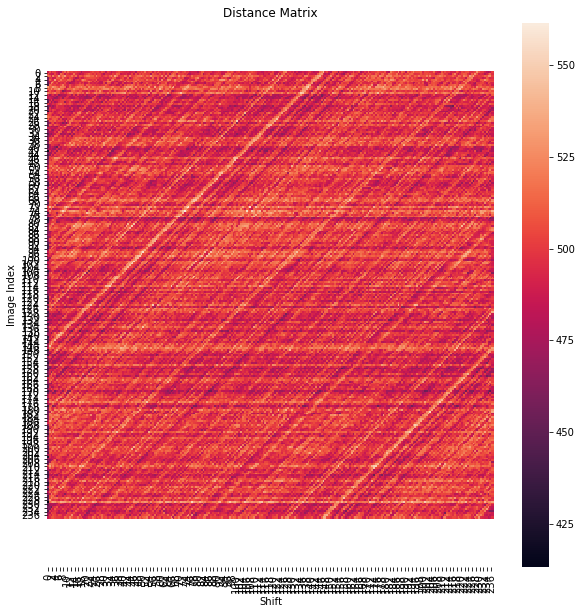

In [6]:
# visualize
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
fig_size = [10,10]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(dst,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Distance Matrix')
plt.show()

### 3. analyse the feature maps

In [7]:
print('Min, Max and Mean of Distances:')
print(np.min(dst), np.max(dst), np.average(dst))
lower, higher = np.min(dst), np.max(dst)

dst_t, dst_f = dst[:,0], dst[:,1:]
#print(dst_t.shape, dst_f.shape)
print('Min, Max and Mean of paired images:', np.min(dst_t), np.max(dst_t), np.mean(dst_t))
print('Min, Max and Mean of unpaired images:', np.min(dst_f), np.max(dst_f), np.mean(dst_f))

print('Sorted distance of paired images:')
print(np.sort(dst_t))

print('First n sorted distance of unpaired images:')
print(np.sort(dst_f.flatten())[:n])

Min, Max and Mean of Distances:
413.2803693335921 561.4919744113273 499.64665085711243
Min, Max and Mean of paired images: 413.2803693335921 529.2002469782201 463.64470352240284
Min, Max and Mean of unpaired images: 449.1260462809641 561.4919744113273 499.79855780789177
Sorted distance of paired images:
[413.28036933 418.96108262 428.13279198 430.65109376 431.56616121
 431.96847366 432.48114257 434.50131889 434.56849118 435.68534354
 435.68695613 437.03129309 437.2981292  438.65631665 438.97377917
 439.31352107 439.33741396 439.47582894 439.94428773 440.52797357
 440.5298884  440.75178385 440.86462812 440.88505417 441.3783304
 441.64120903 441.862245   442.26757822 443.45858246 443.62143894
 444.04194948 444.12047975 444.1750594  444.47645342 444.59186244
 444.72743614 444.87981067 445.30926056 445.40799205 445.47102751
 445.57499156 445.82049927 445.99382991 446.32142028 446.66079656
 447.00039135 447.0655632  447.12618263 447.29232718 447.30068071
 447.51070824 448.18726309 448.36737

TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:
(133, 192, 56214, 105, 0.5588235294117647, 0.0034038932028507603, 0.9947567262198997, 0.40923076923076923, 0.5588235294117647, 0.4724689165186501)


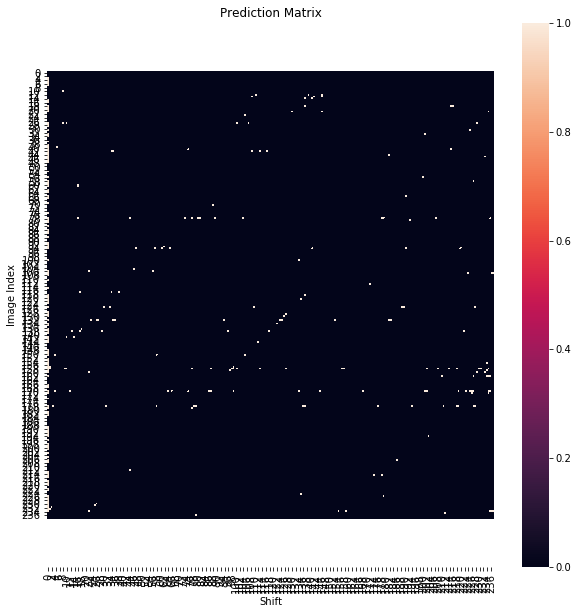

In [8]:
def predict(dst, threshold):
    return (dst <= threshold).astype(np.int)
def ground_truth(dst):
    n = dst.shape[0]
    gt = np.zeros((n,n)).astype(np.int)
    gt[:,0] = 1
    return gt
def confusion_matrix(pred, gt):
    n = gt.shape[0]
    TP = np.sum(gt[:,0] == pred[:,0])
    FN = np.sum(gt[:,0] != pred[:,0])
    TN = np.sum(gt[:,1:] == pred[:,1:])
    FP = np.sum(gt[:,1:] != pred[:,1:])
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

threshold = 465
pred = predict(dst, threshold)
gt = ground_truth(dst)

print("TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:")
print(confusion_matrix(pred, gt))
#%matplotlib inline
plt.axis('equal')
ax = sns.heatmap(pred,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Prediction Matrix')
plt.show()

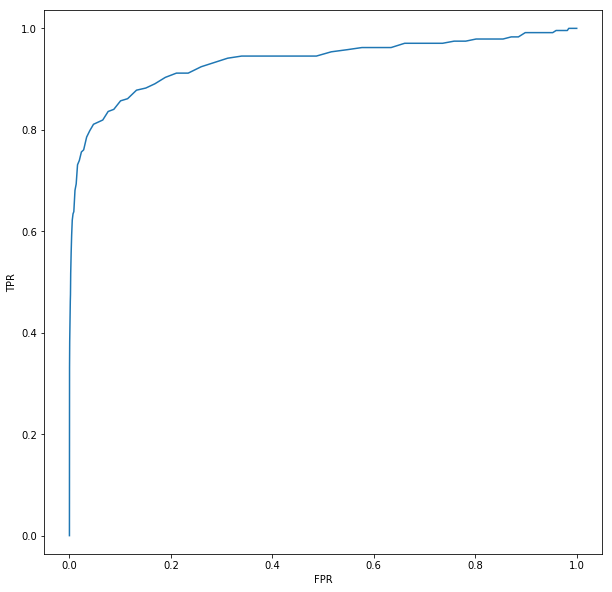

In [9]:
# Draw ROC curve
np.seterr(divide='ignore',invalid='ignore')
ROC_x, ROC_y = [0], [0]
for threshold in range(int(lower),int(higher)+1):
    pred = predict(dst, threshold)
    gt = ground_truth(dst)
    conf_mat = confusion_matrix(pred, gt)
    x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
    ROC_x.append(x)
    ROC_y.append(y)
ROC_x.append(1)
ROC_y.append(1)
#%matplotlib inline
plt.plot(ROC_x, ROC_y)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis('equal')
plt.show()